In [ ]:
#Modeling with features complete.csv and tests_latest_state_level.csv which contains Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated
#and coronaenquirycalls,cumulativepeopleinquarantine,negative,numcallsstatehelpline,numicubeds,numisolationbeds,numventilators,populationncp2019projection,positive,source1,source2,state,tagpeopleinquarantine,tagtotaltested,testpositivityrate,testspermillion,testsperpositivecase,testsperthousand,totaln95masks,totalpeoplecurrentlyinquarantine,totalpeoplereleasedfromquarantine,totalppe,totaltested,unconfirmed,updatedon,_d415a
#Merge these 2 files at a state level with common key as Date. The merging is already been done in tseries_analysis_full_singlestep_forecats

In [ ]:
#The code uses snippets from machine learning mastery for building the main blocks of deep learning models. https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/ 

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import csv
import sys
import matplotlib.pyplot as plt
from sklearn import preprocessing
import mplcursors
import datetime
from pmdarima.arima import auto_arima
from fbprophet import Prophet
import statsmodels.api as sm
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from tslearn.svm import TimeSeriesSVR
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
from numpy import array
from math import sqrt
from numpy import split

startDate ='2020-01-30'
endDate = '2020-06-05'

In [227]:
from tensorflow.python.keras.layers import Dense, LSTM, RepeatVector
from tensorflow.python.keras import Sequential 

from tensorflow.python.keras.layers import TimeDistributed,Flatten, Bidirectional
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling1D
from tensorflow.python.keras.layers.convolutional_recurrent import ConvLSTM2D

In [228]:
ModelType ='CONV2_LSTM' #change it to LSTM/CNN/LSTM_CNN/CONV2_LSTM

In [230]:
# Function to find the number closest  to input train datasizee of  and divisible by 7 (number of days in a week)
def closestNumber(n, m):
    # Find the quotient
    q = int(n / m)

    n1 = m * q

    if ((n * m) > 0):
        n2 = (m * (q + 1))
    else:
        n2 = (m * (q - 1))

    if (abs(n - n1) < abs(n - n2)):
        return n1

    return n2

In [231]:
# split a multivariate dataset into train/test sets
def split_dataset(data):
# split into standard weeks
    print(np.shape(data))
    split_factor = int((np.shape(data)[0]*0.7))
    print("Split Factor no is", split_factor)

    m = 7
    trn_close_no = closestNumber(split_factor, m)
    te_close_no = closestNumber((np.shape(data)[0]-split_factor), m)

    train, test = data[0:trn_close_no], data[trn_close_no:(trn_close_no + te_close_no)]
    print("Initials Train-Test Split --", np.shape(train), np.shape(test))

    len_train = np.shape(train)[0]
    len_test = np.shape(test)[0]

    # restructure into windows of weekly data
    train = array(split(train[0:len_train], len(train[0:len_train]) / 7))
    test = array(split(test, len(test) / 7))

    print("Final Train-Test Split --", np.shape(train), np.shape(test))
    return train, test



In [232]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    print("Actual Results", np.shape(actual))
    print("Predicted  Results",  np.shape(predicted))

    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)

        plt.figure(figsize=(14, 12))
        plt.plot(actual[:, i], label='actual')
        plt.plot(predicted[:, i], label='predicted') 
        plt.title(ModelType + ' based Multi-Step Time Series Active Cases Prediction for step ' + str(i)) 
        plt.legend()
        plt.show()

    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [233]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [234]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [235]:
# train CNN model
def build_model_cnn(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 200, 4
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [236]:
# train LSTM model
def build_model_lstm(train, n_input):
    
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    print(np.shape(train_x))
    print(np.shape(train_y))
    # define parameters
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [237]:
# train Bi-Directionsl LSTM model
def build_model_bi_lstm(train, n_input):
    
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    print(np.shape(train_x))
    print(np.shape(train_y))
    # define parameters
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))))
    model.add(RepeatVector(n_outputs))
    model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True)))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [238]:
# train Stacked CNN + LSTM model
def build_model_cnn_lstm(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 500, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [239]:
# make a forecast 
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    if(ModelType == 'LSTM'):
           input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    if(ModelType == 'BI_LSTM'):
           input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    elif(ModelType == 'CNN'):
           input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    elif(ModelType == 'LSTM_CNN'):
           input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [240]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    model = None
    # fit model
    if(ModelType == 'LSTM'):
        print('lstm')
        model = build_model_lstm(train, n_input)
    elif(ModelType == 'BI_LSTM'):
        print('bi_lstm')
        model = build_model_bi_lstm(train, n_input)
    elif(ModelType == 'CNN'):
        print('cnn')
        model = build_model_cnn(train, n_input)
    elif(ModelType == 'LSTM_CNN'):
        print('lstm_cnn')
        model = build_model_cnn_lstm(train, n_input)
        
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, test[:, :, 0], predictions

In [241]:
unique_states = ['Andaman and Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh',
 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh',
 'Dadra and Nagar Haveli and Daman and Diu', 'Delhi', 'Goa', 'Gujarat',
 'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand', 'Karnataka',
 'Kerala', 'Ladakh', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya',
 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand',
 'West Bengal']

# Multi Step LSTM based Prediction for State Delhi

(4480, 30)
Delhi
(96, 30)
Delhi
(73, 30)
2020-03-25
2020-06-05
(73, 23)
(73, 23)
Split Factor no is 51
Initials Train-Test Split -- (49, 23) (21, 23)
Final Train-Test Split -- (7, 7, 23) (3, 7, 23)
Index(['Active Cases', 'Cured/Discharged/Migrated', 'Death',
       'Total Confirmed cases', 'coronaenquirycalls',
       'cumulativepeopleinquarantine', 'negative', 'numcallsstatehelpline',
       'numicubeds', 'numisolationbeds', 'numventilators',
       'populationncp2019projection', 'positive', 'testpositivityrate',
       'testspermillion', 'testsperpositivecase', 'testsperthousand',
       'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed'],
      dtype='object')
lstm
(36, 7, 23)
(36, 7)
Actual Results (3, 7)
Predicted  Results (3, 7, 1)


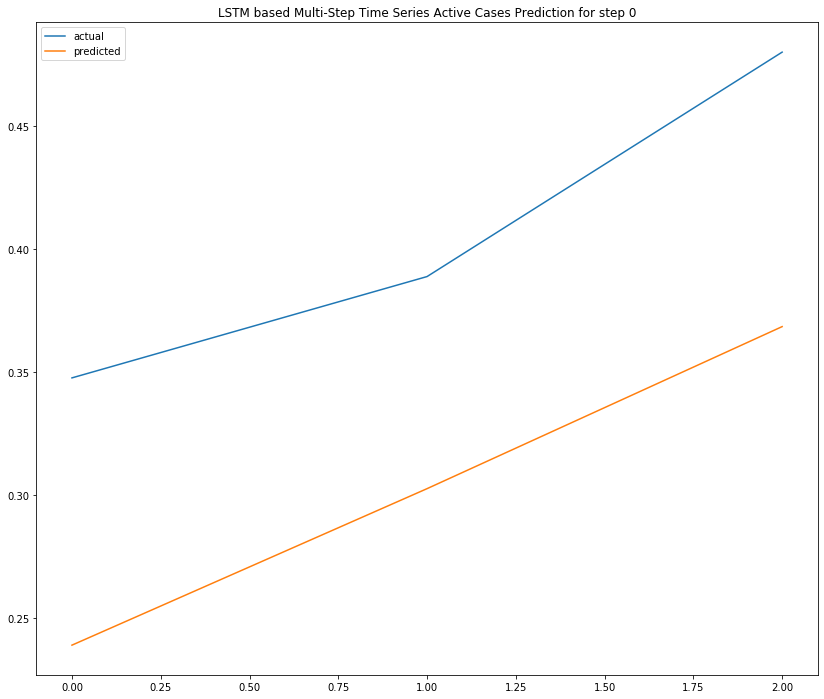

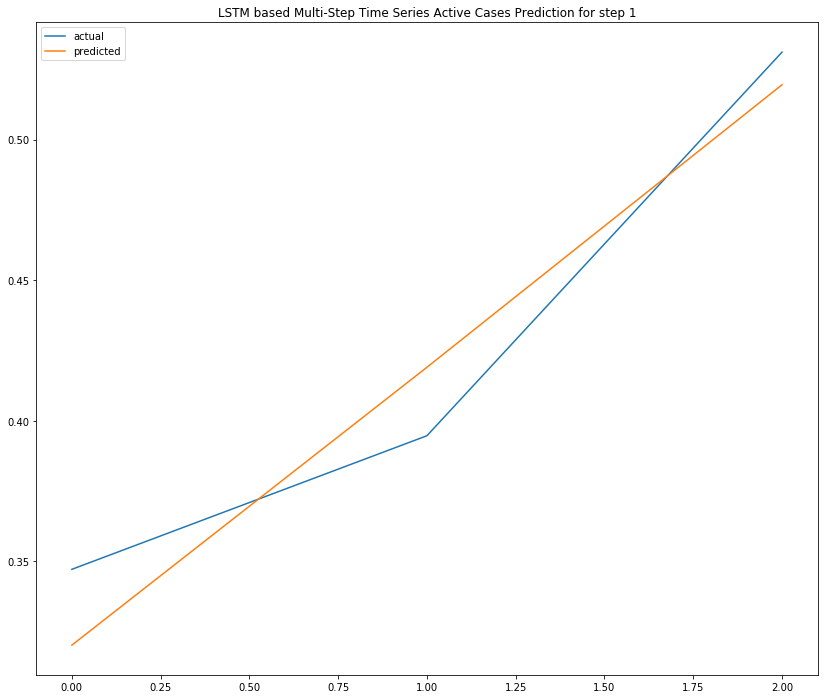

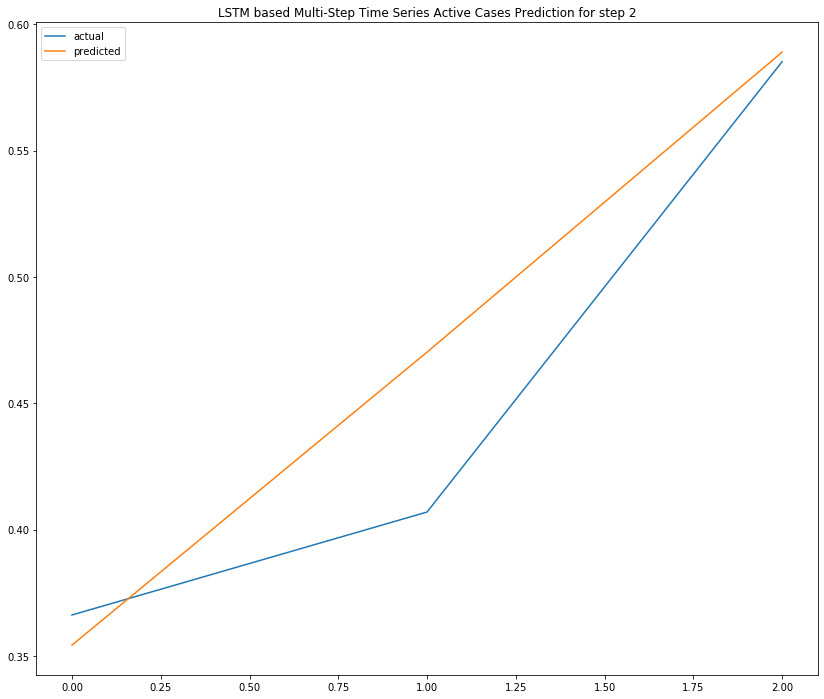

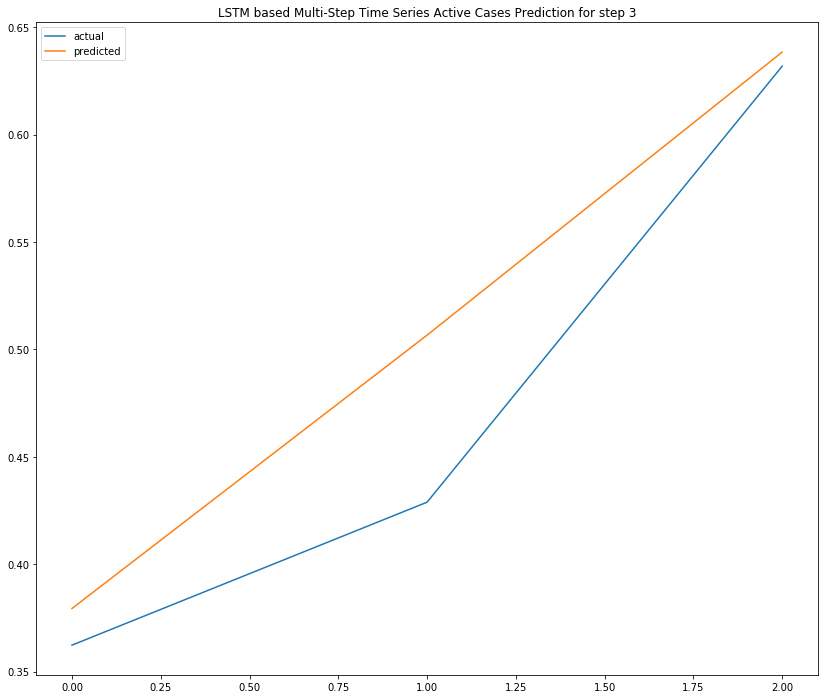

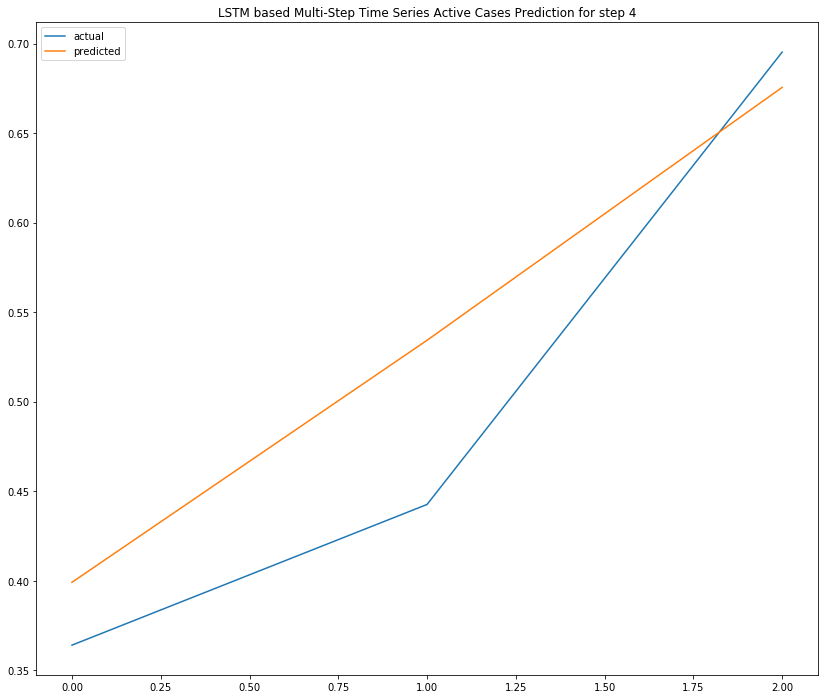

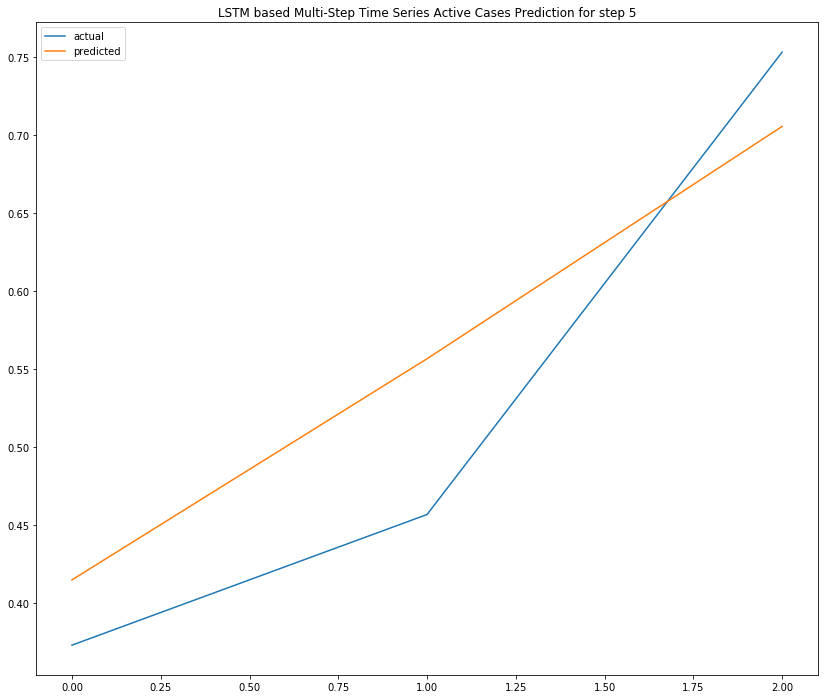

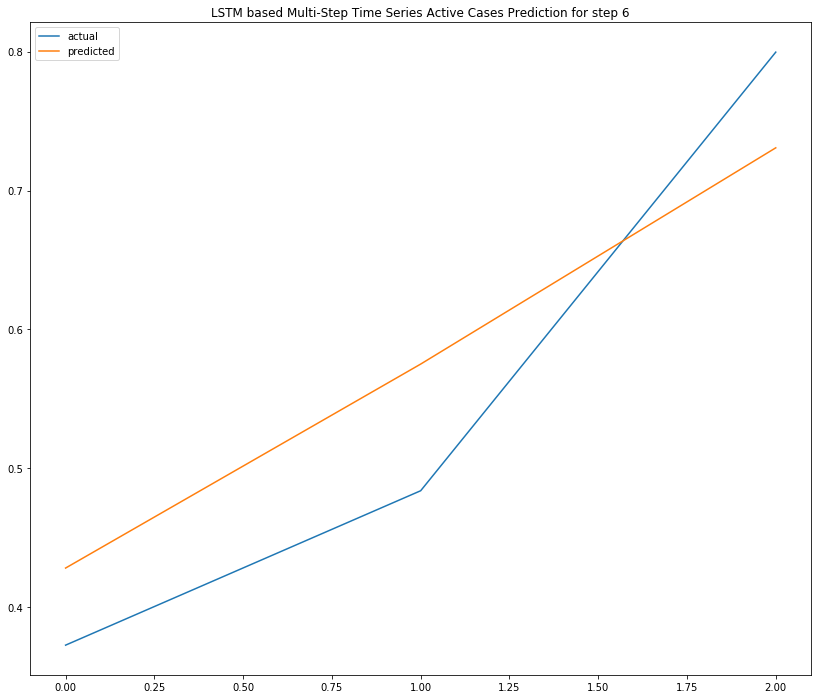

LSTM: [0.063] 0.1, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1


In [15]:
df_state_all = pd.read_csv('all_states/all.csv')
df_state_all = df_state_all.drop(columns=['Latitude', 'Longitude', 'index'])
stateName = unique_states[8]
print(np.shape(df_state_all))
print(stateName)


dataset = df_state_all[df_state_all['Name of State / UT'] == unique_states[8]]
dataset = dataset.sort_values(by='Date', ascending=True)
print(np.shape(dataset))
print(stateName)
dataset = dataset[(dataset['Date'] >= '2020-03-25') & (dataset['Date'] <= '2020-06-06')]

print(np.shape(dataset))
daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]
print(dateStart)
print(dateEnd)


dataset = dataset.drop(columns=['Unnamed: 0', 'Date', 'source1', 'state', 'Name of State / UT', 'tagpeopleinquarantine', 'tagtotaltested'])
print(np.shape(dataset))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# split into train and test
train, test = split_dataset(scaled_dataset)
print(dataset.columns)


# evaluate model and get scores
n_input =7
score, scores, actual, predicted = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores(ModelType, score, scores)

2020-05-13
21 (21, 23)
2020-06-03
(21,)
(21,)


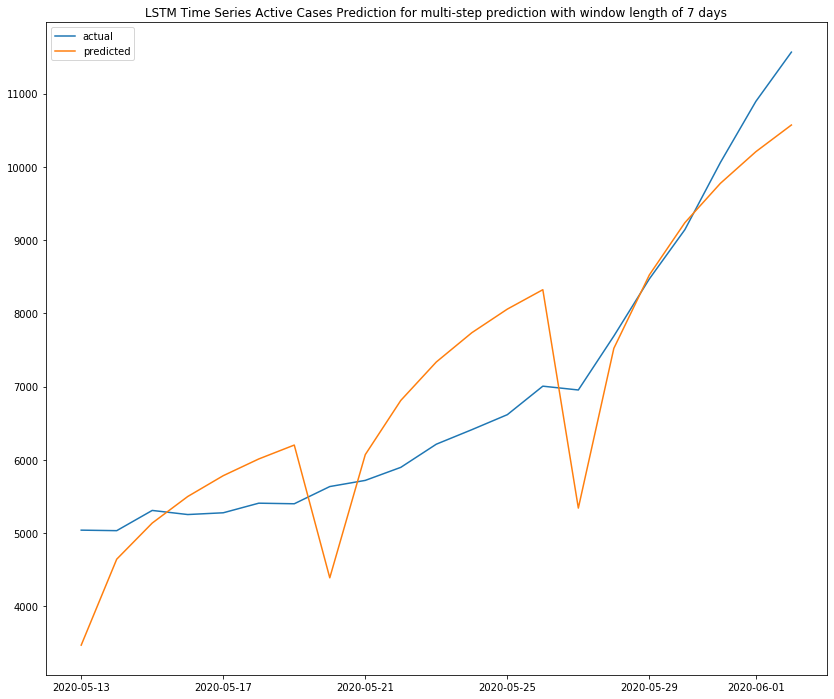

Test RMSE: 912.224


In [16]:
test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
#print(np.shape(test))

actual = actual.reshape((actual.shape[0]*actual.shape[1], 1))
#print(np.shape(actual))

predicted = predicted.reshape((predicted.shape[0]*predicted.shape[1], 1))
#print(np.shape(predicted))


inv_pred = np.concatenate((predicted, test[:, 1:]), axis=1)
#print(np.shape(inv_pred))


inv_y = np.concatenate((actual, test[:, 1:]), axis=1)
#print(np.shape(inv_y))


inv_pred = scaler.inverse_transform(inv_pred)
#print(np.shape(inv_pred))
inv_pred = inv_pred[:, 0]

inv_y = scaler.inverse_transform(inv_y)
#print(np.shape(inv_y))
inv_y = inv_y[:, 0]


#For plotting
ind_dend=np.shape(test)[0]
ind_dstart =  np.shape(train)[0] *np.shape(train)[1]
dateStart = daterange[ind_dstart]
print(dateStart)
print(ind_dend,np.shape(test))
dateEnd = daterange[ind_dstart+ind_dend]
print(dateEnd)

pred_index= pd.date_range(start=dateStart, periods=ind_dend, freq='D')
print(np.shape(inv_y))
print(np.shape(inv_pred))

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_pred, pred_index)


plt.figure(figsize=(14, 12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title(ModelType +  ' Time Series Active Cases Prediction for multi-step prediction with window length of 7 days')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)

# Multi Step Bi-directional LSTM based Prediction for State Delhi

(4480, 30)
Delhi
(96, 30)
Delhi
(73, 30)
2020-03-25
2020-06-05
(73, 23)
(73, 23)
Split Factor no is 51
Initials Train-Test Split -- (49, 23) (21, 23)
Final Train-Test Split -- (7, 7, 23) (3, 7, 23)
Index(['Active Cases', 'Cured/Discharged/Migrated', 'Death',
       'Total Confirmed cases', 'coronaenquirycalls',
       'cumulativepeopleinquarantine', 'negative', 'numcallsstatehelpline',
       'numicubeds', 'numisolationbeds', 'numventilators',
       'populationncp2019projection', 'positive', 'testpositivityrate',
       'testspermillion', 'testsperpositivecase', 'testsperthousand',
       'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed'],
      dtype='object')
bi_lstm
(36, 7, 23)
(36, 7)
Actual Results (3, 7)
Predicted  Results (3, 7, 1)


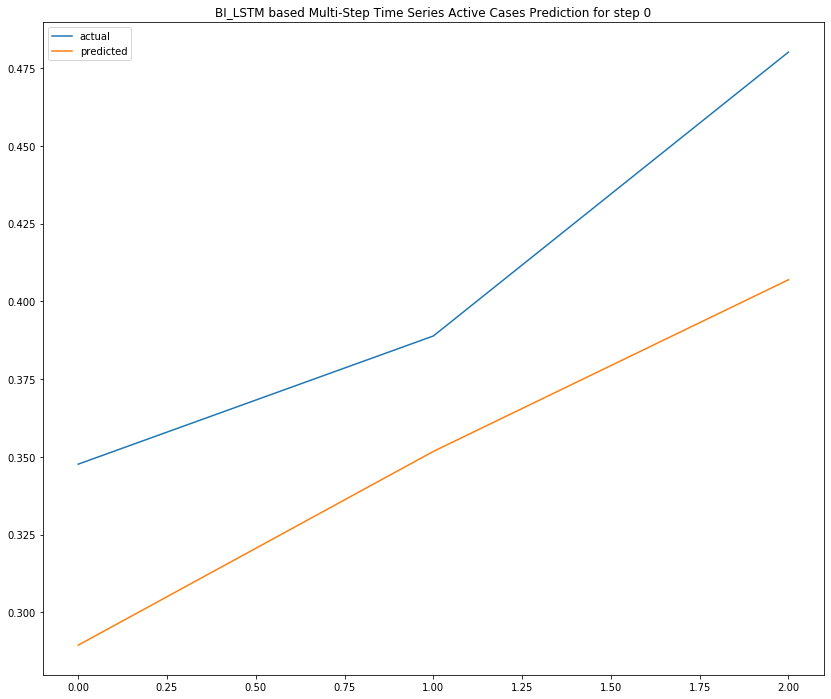

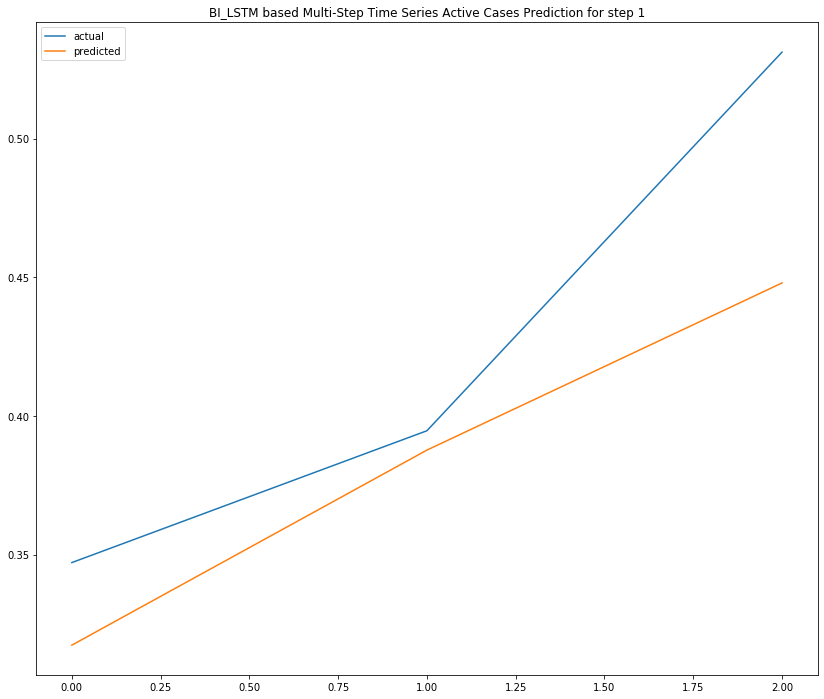

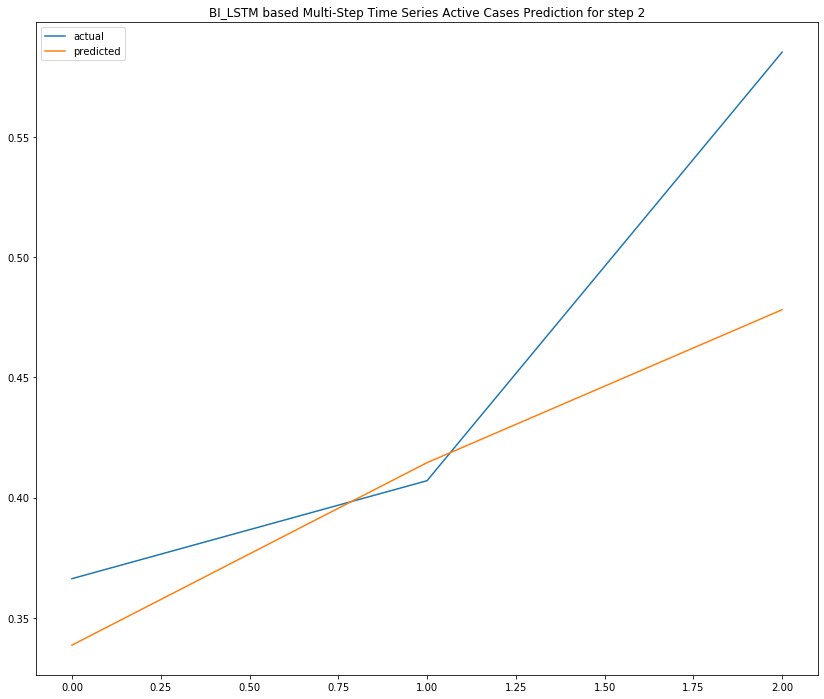

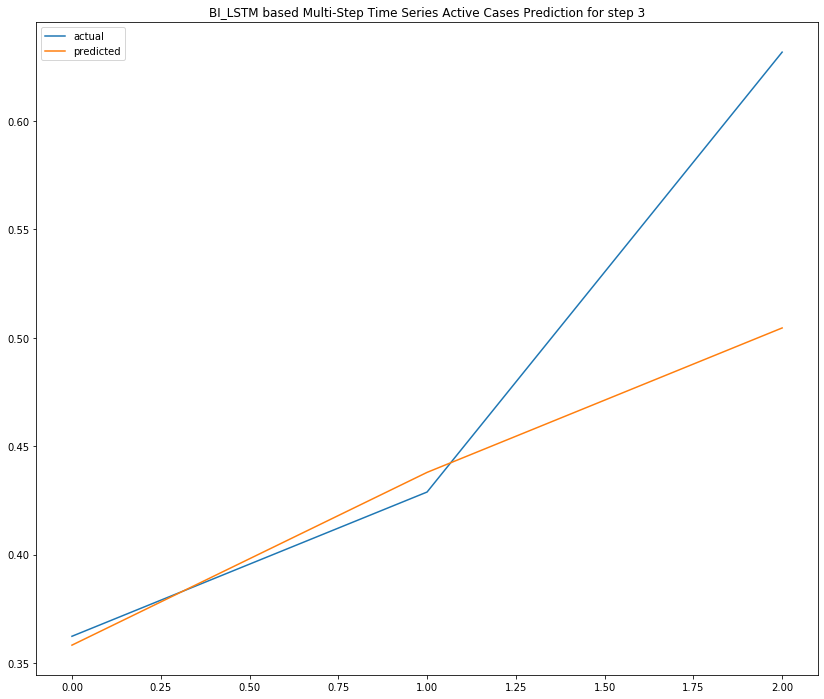

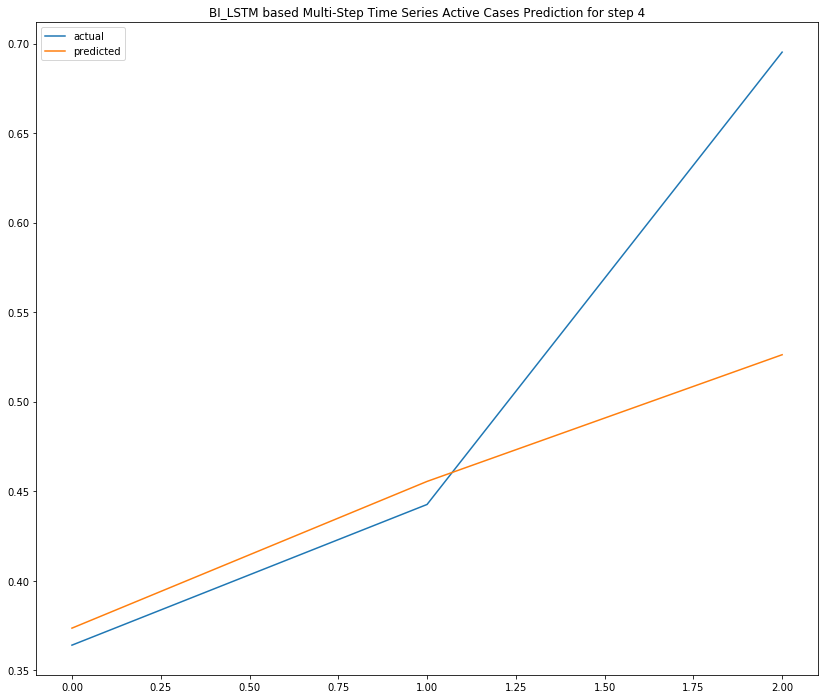

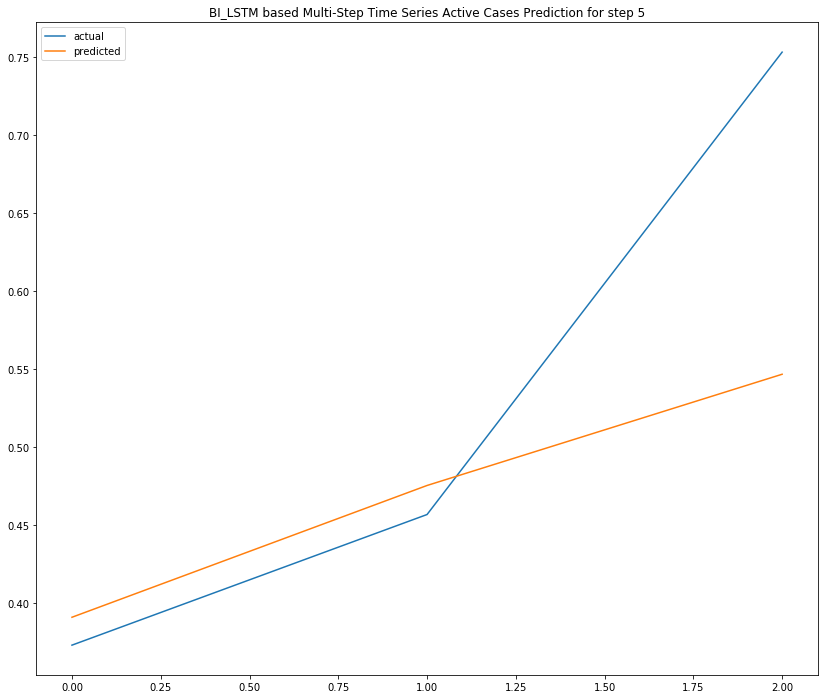

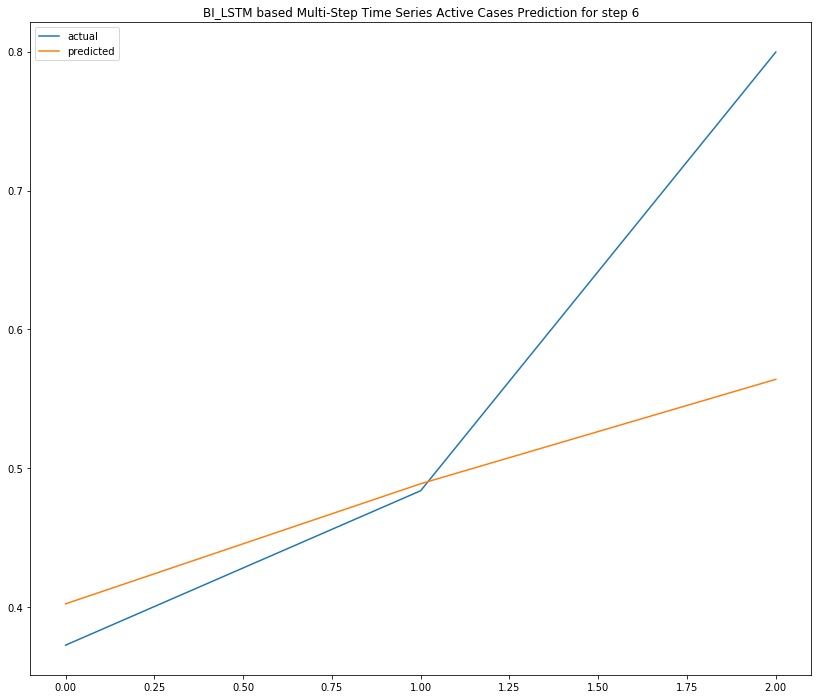

BI_LSTM: [0.091] 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1


In [37]:
df_state_all = pd.read_csv('all_states/all.csv')
df_state_all = df_state_all.drop(columns=['Latitude', 'Longitude', 'index'])
stateName = unique_states[8]
print(np.shape(df_state_all))
print(stateName)


dataset = df_state_all[df_state_all['Name of State / UT'] == unique_states[8]]
dataset = dataset.sort_values(by='Date', ascending=True)
print(np.shape(dataset))
print(stateName)
dataset = dataset[(dataset['Date'] >= '2020-03-25') & (dataset['Date'] <= '2020-06-06')]

print(np.shape(dataset))
daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]
print(dateStart)
print(dateEnd)


dataset = dataset.drop(columns=['Unnamed: 0', 'Date', 'source1', 'state', 'Name of State / UT', 'tagpeopleinquarantine', 'tagtotaltested'])
print(np.shape(dataset))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# split into train and test
train, test = split_dataset(scaled_dataset)
print(dataset.columns)


# evaluate model and get scores
n_input =7
score, scores, actual, predicted = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores(ModelType, score, scores)

2020-05-13
21 (21, 23)
2020-06-03
(21,)
(21,)


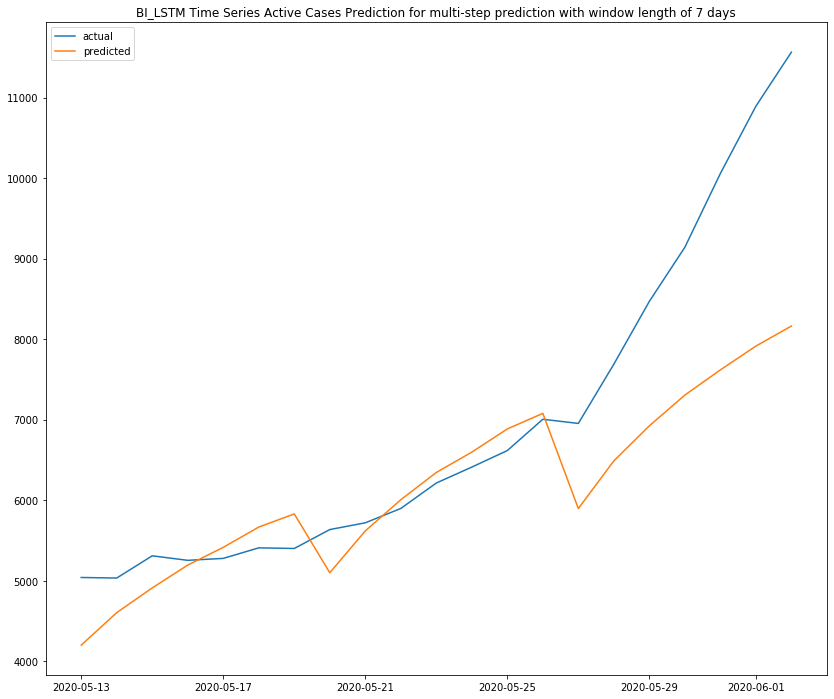

Test RMSE: 1317.841


In [38]:
test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
#print(np.shape(test))

actual = actual.reshape((actual.shape[0]*actual.shape[1], 1))
#print(np.shape(actual))

predicted = predicted.reshape((predicted.shape[0]*predicted.shape[1], 1))
#print(np.shape(predicted))


inv_pred = np.concatenate((predicted, test[:, 1:]), axis=1)
#print(np.shape(inv_pred))


inv_y = np.concatenate((actual, test[:, 1:]), axis=1)
#print(np.shape(inv_y))


inv_pred = scaler.inverse_transform(inv_pred)
#print(np.shape(inv_pred))
inv_pred = inv_pred[:, 0]

inv_y = scaler.inverse_transform(inv_y)
#print(np.shape(inv_y))
inv_y = inv_y[:, 0]


#For plotting
ind_dend=np.shape(test)[0]
ind_dstart =  np.shape(train)[0] *np.shape(train)[1]
dateStart = daterange[ind_dstart]
print(dateStart)
print(ind_dend,np.shape(test))
dateEnd = daterange[ind_dstart+ind_dend]
print(dateEnd)

pred_index= pd.date_range(start=dateStart, periods=ind_dend, freq='D')
print(np.shape(inv_y))
print(np.shape(inv_pred))

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_pred, pred_index)


plt.figure(figsize=(14, 12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title(ModelType +  ' Time Series Active Cases Prediction for multi-step prediction with window length of 7 days')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)

# Multi Step CNN based Prediction for State Delhi

(4480, 30)
Delhi
(96, 30)
Delhi
(73, 30)
2020-03-25
2020-06-05
(73, 23)
(73, 23)
Split Factor no is 51
Initials Train-Test Split -- (49, 23) (21, 23)
Final Train-Test Split -- (7, 7, 23) (3, 7, 23)
Index(['Active Cases', 'Cured/Discharged/Migrated', 'Death',
       'Total Confirmed cases', 'coronaenquirycalls',
       'cumulativepeopleinquarantine', 'negative', 'numcallsstatehelpline',
       'numicubeds', 'numisolationbeds', 'numventilators',
       'populationncp2019projection', 'positive', 'testpositivityrate',
       'testspermillion', 'testsperpositivecase', 'testsperthousand',
       'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed'],
      dtype='object')
cnn
Actual Results (3, 7)
Predicted  Results (3, 7)


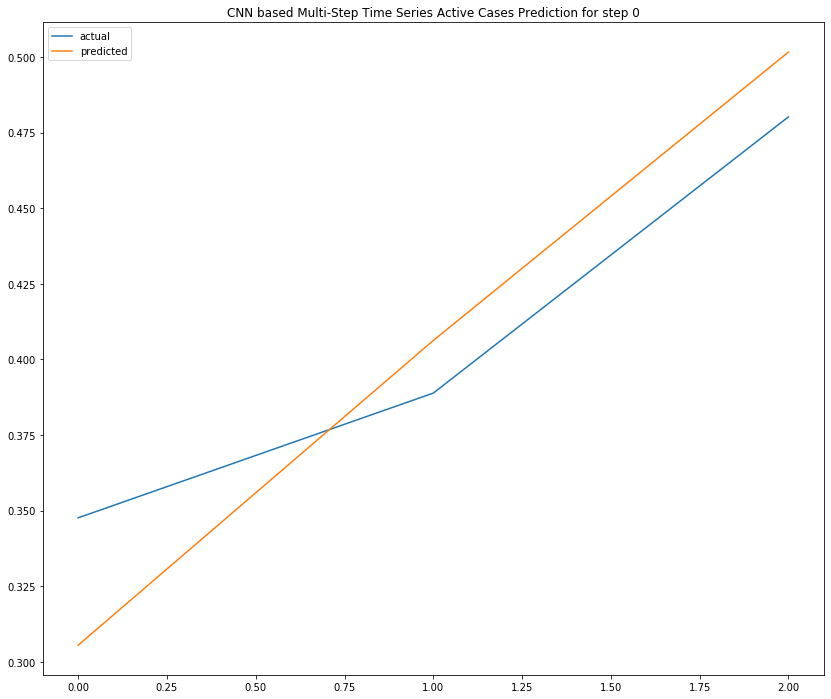

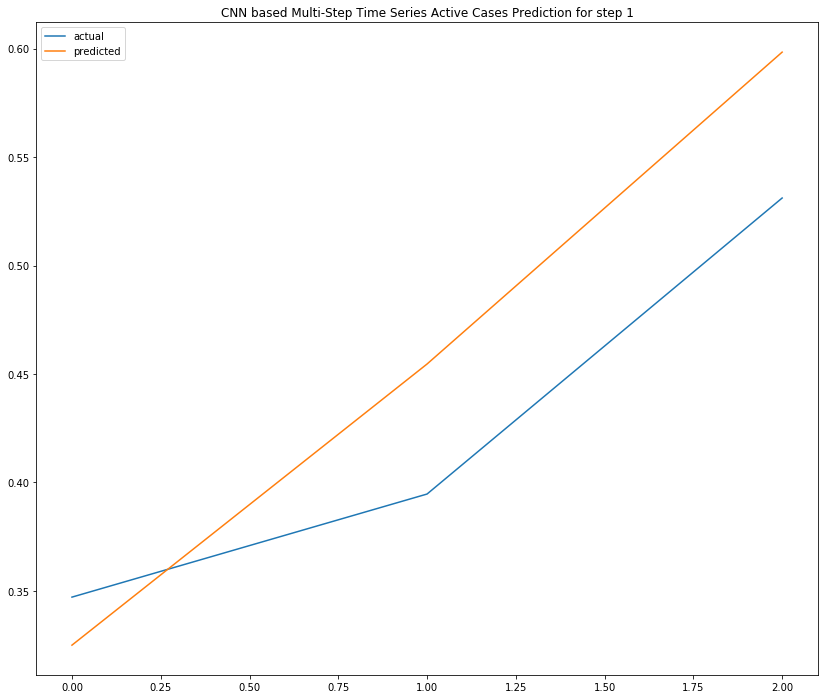

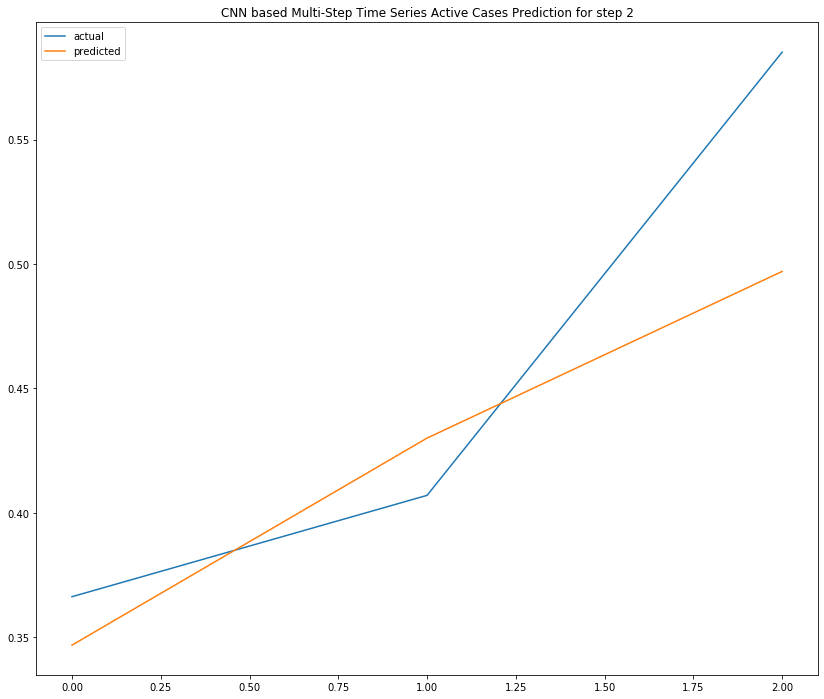

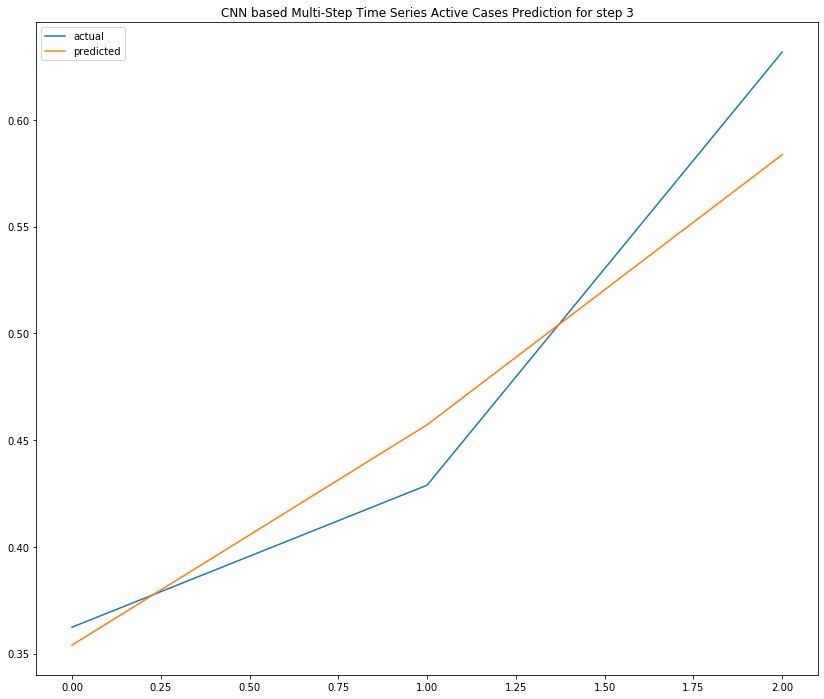

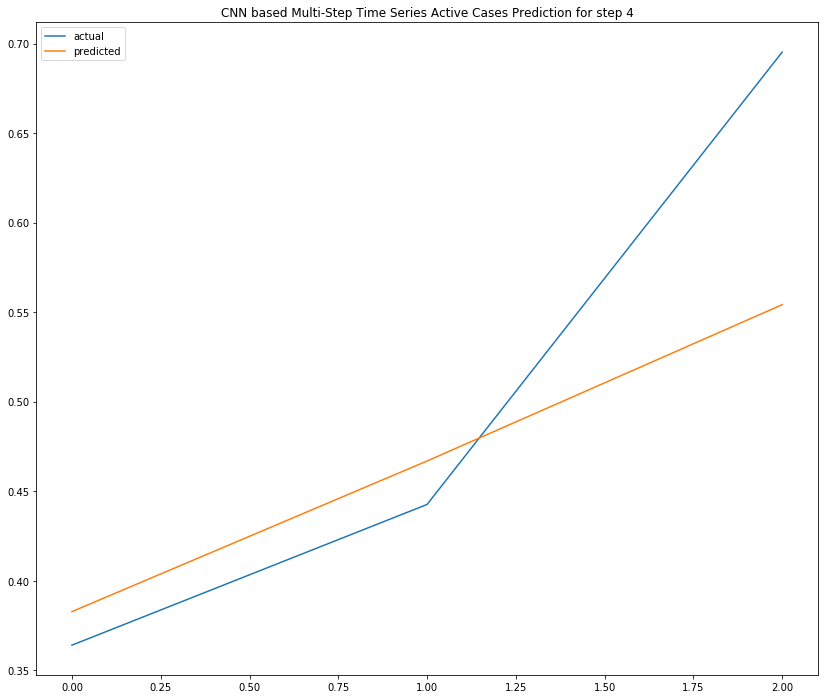

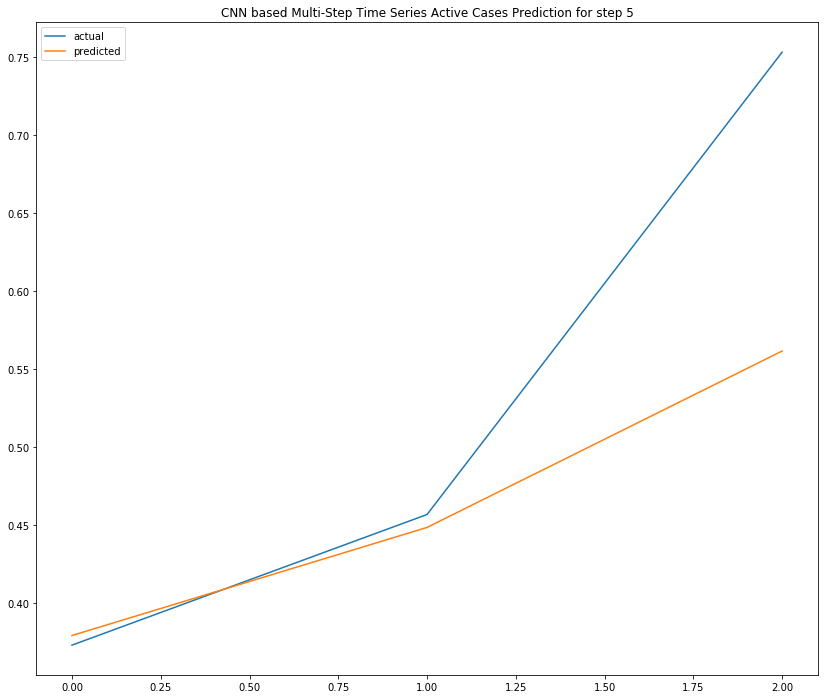

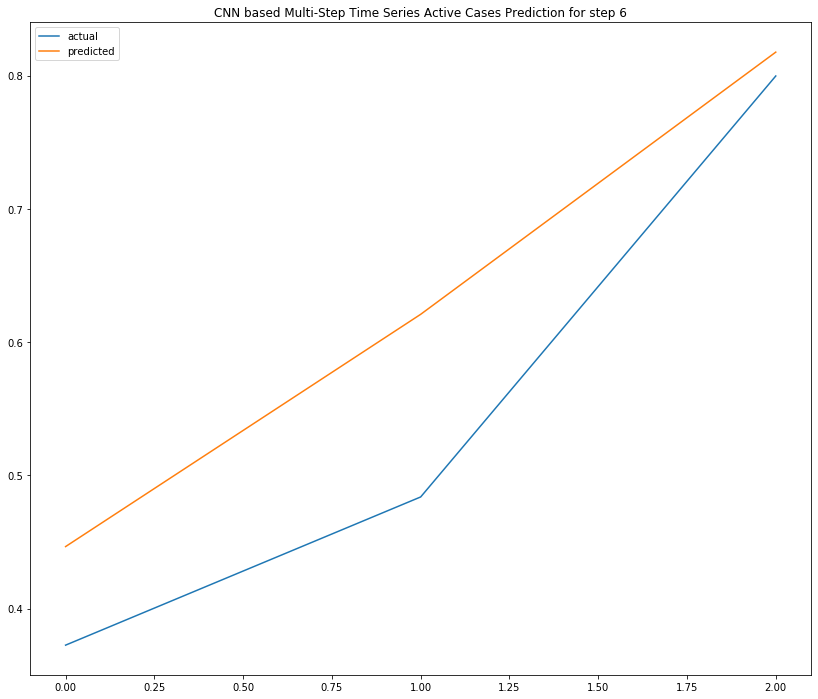

CNN: [0.071] 0.0, 0.1, 0.1, 0.0, 0.1, 0.1, 0.1


In [18]:
df_state_all = pd.read_csv('all_states/all.csv')
df_state_all = df_state_all.drop(columns=['Latitude', 'Longitude', 'index'])
stateName = unique_states[8]
print(np.shape(df_state_all))
print(stateName)


dataset = df_state_all[df_state_all['Name of State / UT'] == unique_states[8]]
dataset = dataset.sort_values(by='Date', ascending=True)
print(np.shape(dataset))
print(stateName)
dataset = dataset[(dataset['Date'] >= '2020-03-25') & (dataset['Date'] <= '2020-06-06')]

print(np.shape(dataset))
daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]
print(dateStart)
print(dateEnd)


dataset = dataset.drop(columns=['Unnamed: 0', 'Date', 'source1', 'state', 'Name of State / UT', 'tagpeopleinquarantine', 'tagtotaltested'])
print(np.shape(dataset))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# split into train and test
train, test = split_dataset(scaled_dataset)
print(dataset.columns)


# evaluate model and get scores
n_input =14
score, scores, actual, predicted = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores(ModelType, score, scores)

2020-05-13
21 (21, 23)
2020-06-03
(21,)
(21,)


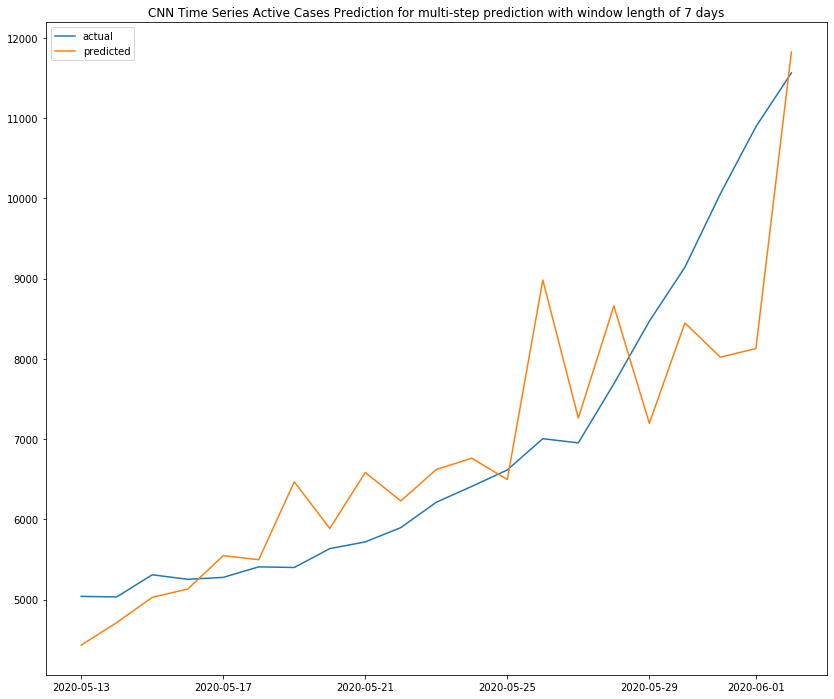

Test RMSE: 1021.518


In [19]:
test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
#print(np.shape(test))

actual = actual.reshape((actual.shape[0]*actual.shape[1], 1))
#print(np.shape(actual))

predicted = predicted.reshape((predicted.shape[0]*predicted.shape[1], 1))
#print(np.shape(predicted))


inv_pred = np.concatenate((predicted, test[:, 1:]), axis=1)
#print(np.shape(inv_pred))


inv_y = np.concatenate((actual, test[:, 1:]), axis=1)
#print(np.shape(inv_y))


inv_pred = scaler.inverse_transform(inv_pred)
#print(np.shape(inv_pred))
inv_pred = inv_pred[:, 0]

inv_y = scaler.inverse_transform(inv_y)
#print(np.shape(inv_y))
inv_y = inv_y[:, 0]



#For plotting
ind_dend=np.shape(test)[0]
ind_dstart =  np.shape(train)[0] *np.shape(train)[1]
dateStart = daterange[ind_dstart]
print(dateStart)
print(ind_dend,np.shape(test))
dateEnd = daterange[ind_dstart+ind_dend]
print(dateEnd)

pred_index= pd.date_range(start=dateStart, periods=ind_dend, freq='D')
print(np.shape(inv_y))
print(np.shape(inv_pred))

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_pred, pred_index)


plt.figure(figsize=(14, 12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title(ModelType +  ' Time Series Active Cases Prediction for multi-step prediction with window length of 7 days')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)

# Multi Step CNN +LSTM based Prediction for State Delhi

(4480, 30)
Delhi
(96, 30)
Delhi
(73, 30)
2020-03-25
2020-06-05
(73, 23)
(73, 23)
Split Factor no is 51
Initials Train-Test Split -- (49, 23) (21, 23)
Final Train-Test Split -- (7, 7, 23) (3, 7, 23)
Index(['Active Cases', 'Cured/Discharged/Migrated', 'Death',
       'Total Confirmed cases', 'coronaenquirycalls',
       'cumulativepeopleinquarantine', 'negative', 'numcallsstatehelpline',
       'numicubeds', 'numisolationbeds', 'numventilators',
       'populationncp2019projection', 'positive', 'testpositivityrate',
       'testspermillion', 'testsperpositivecase', 'testsperthousand',
       'totaln95masks', 'totalpeoplecurrentlyinquarantine',
       'totalpeoplereleasedfromquarantine', 'totalppe', 'totaltested',
       'unconfirmed'],
      dtype='object')
lstm_cnn
Actual Results (3, 7)
Predicted  Results (3, 7, 1)


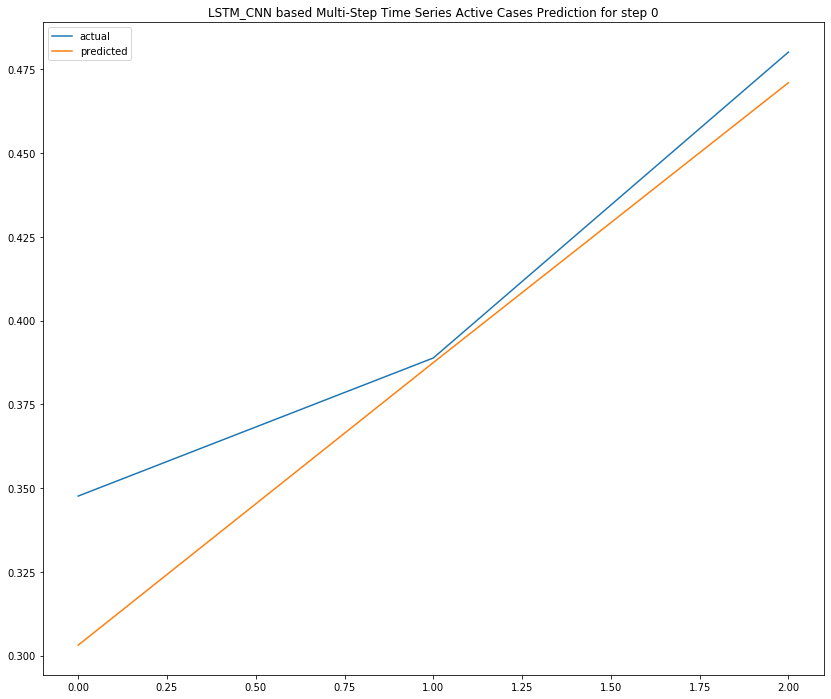

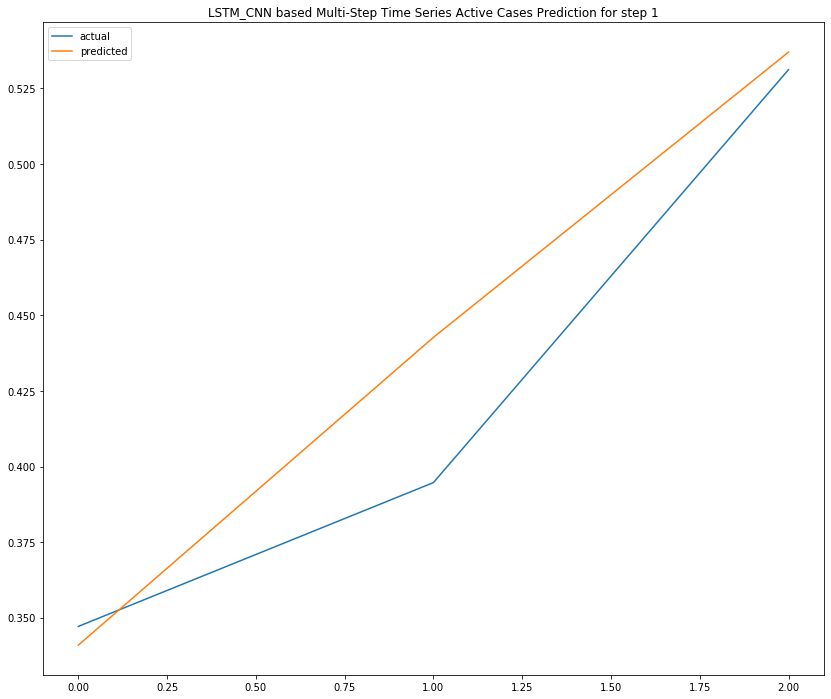

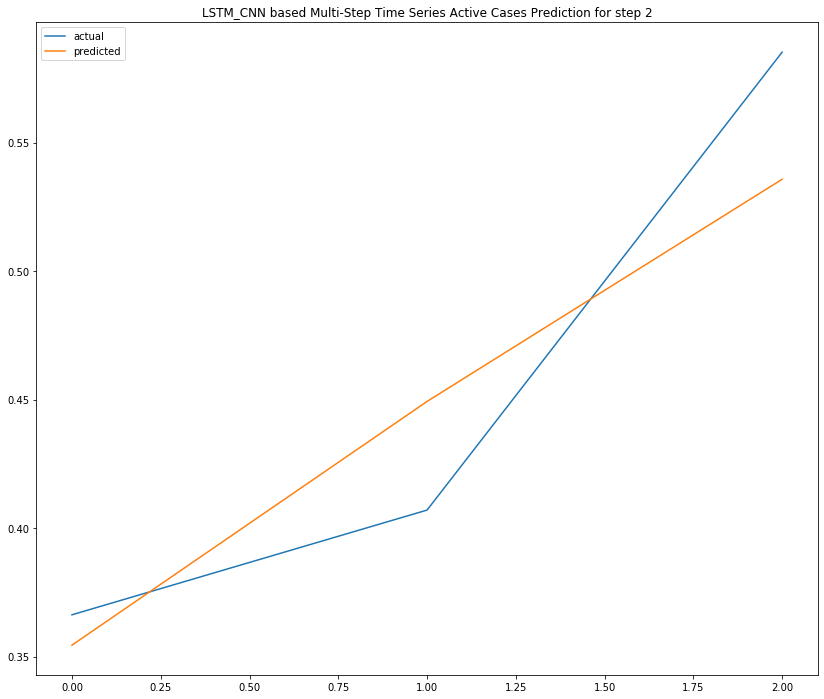

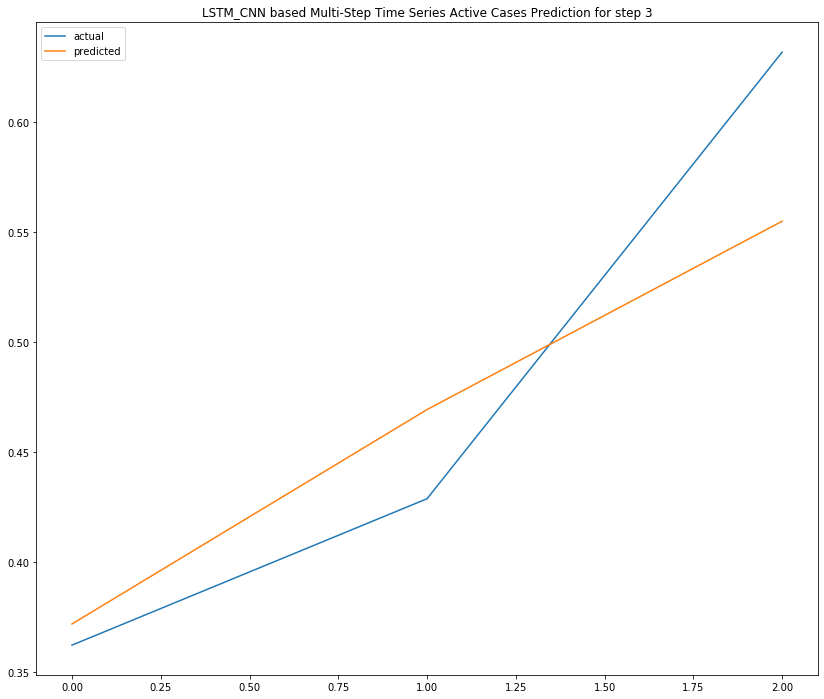

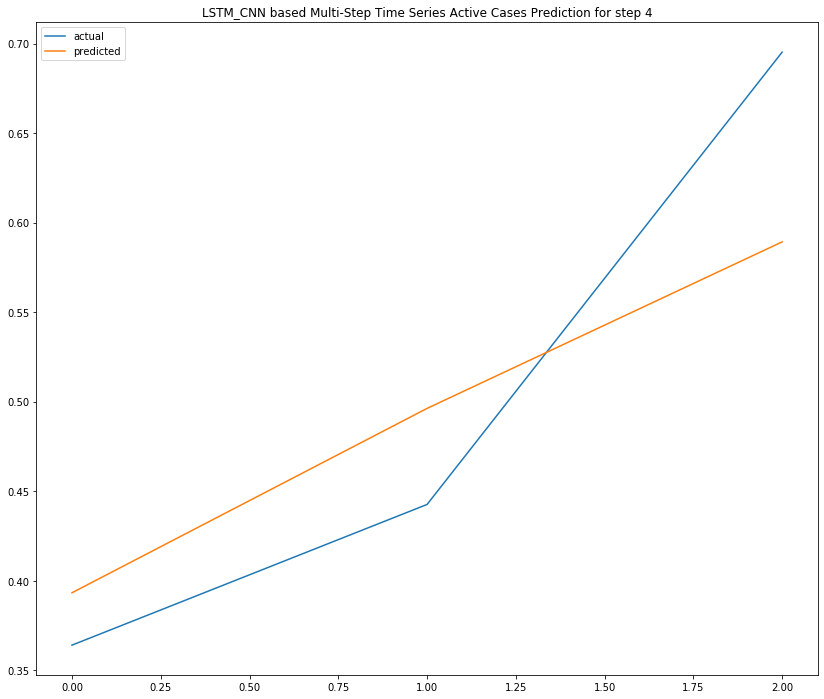

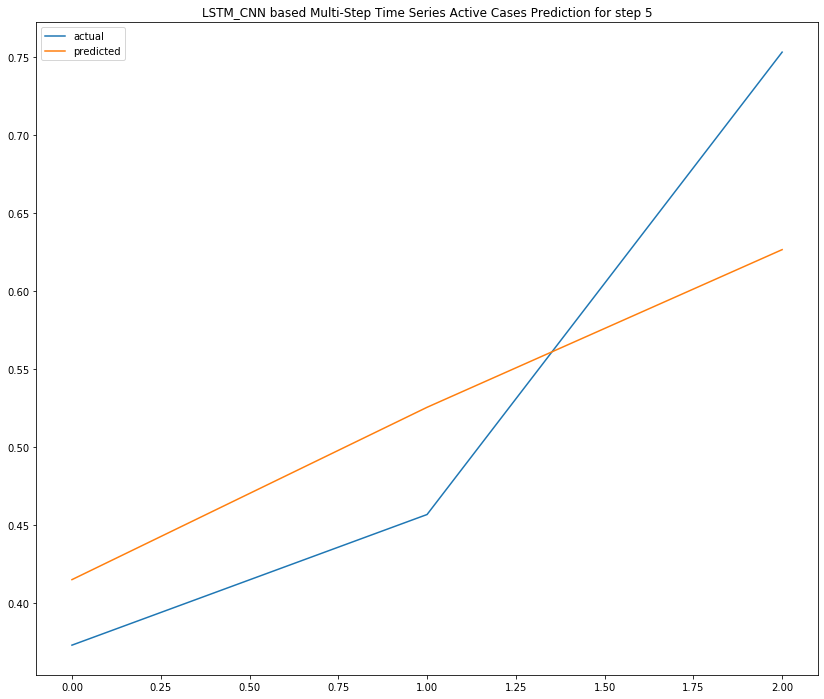

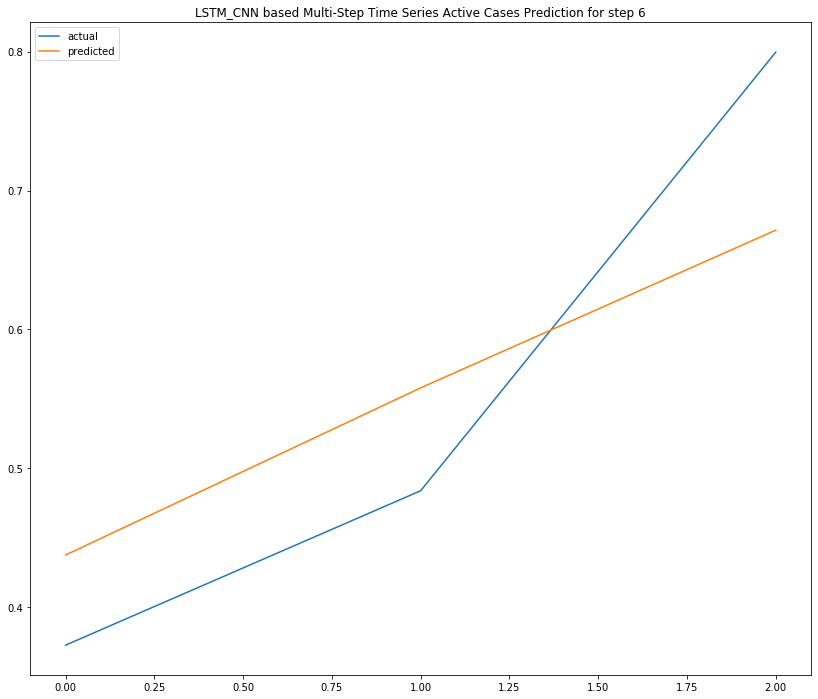

LSTM_CNN: [0.062] 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.1


In [21]:
df_state_all = pd.read_csv('all_states/all.csv')
df_state_all = df_state_all.drop(columns=['Latitude', 'Longitude', 'index'])
stateName = unique_states[8]
print(np.shape(df_state_all))
print(stateName)


dataset = df_state_all[df_state_all['Name of State / UT'] == unique_states[8]]
dataset = dataset.sort_values(by='Date', ascending=True)
print(np.shape(dataset))
print(stateName)
dataset = dataset[(dataset['Date'] >= '2020-03-25') & (dataset['Date'] <= '2020-06-06')]

print(np.shape(dataset))
daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]
print(dateStart)
print(dateEnd)


dataset = dataset.drop(columns=['Unnamed: 0', 'Date', 'source1', 'state', 'Name of State / UT', 'tagpeopleinquarantine', 'tagtotaltested'])
print(np.shape(dataset))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# split into train and test
train, test = split_dataset(scaled_dataset)
print(dataset.columns)


# evaluate model and get scores
n_input =7
score, scores, actual, predicted = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores(ModelType, score, scores)

2020-05-13
21 (21, 23)
2020-06-03
(21,)
(21,)


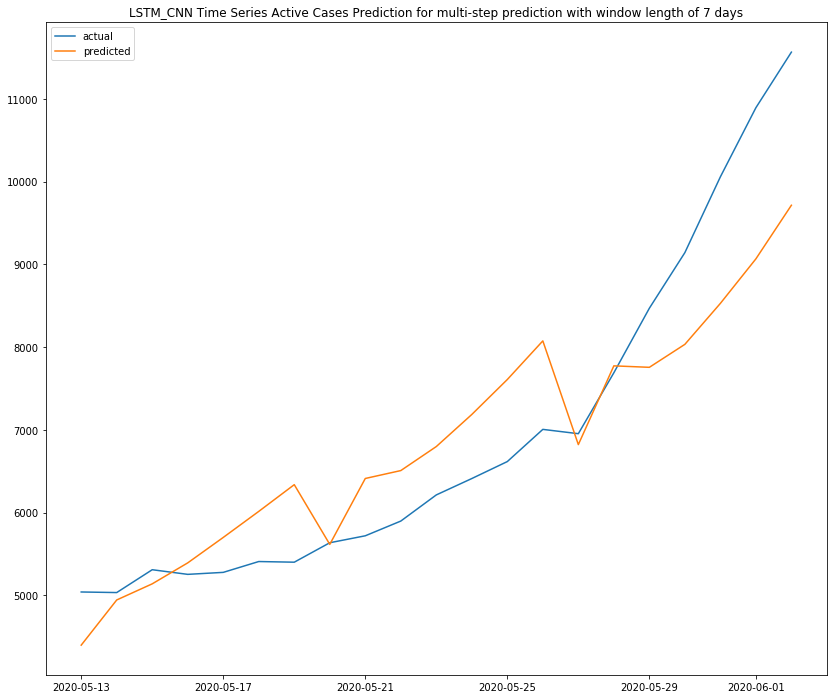

Test RMSE: 891.076


In [22]:
test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
#print(np.shape(test))

actual = actual.reshape((actual.shape[0]*actual.shape[1], 1))
#print(np.shape(actual))

predicted = predicted.reshape((predicted.shape[0]*predicted.shape[1], 1))
#print(np.shape(predicted))


inv_pred = np.concatenate((predicted, test[:, 1:]), axis=1)
#print(np.shape(inv_pred))


inv_y = np.concatenate((actual, test[:, 1:]), axis=1)
#print(np.shape(inv_y))


inv_pred = scaler.inverse_transform(inv_pred)
#print(np.shape(inv_pred))
inv_pred = inv_pred[:, 0]

inv_y = scaler.inverse_transform(inv_y)
#print(np.shape(inv_y))
inv_y = inv_y[:, 0]



#For plotting
ind_dend=np.shape(test)[0]
ind_dstart =  np.shape(train)[0] *np.shape(train)[1]
dateStart = daterange[ind_dstart]
print(dateStart)
print(ind_dend,np.shape(test))
dateEnd = daterange[ind_dstart+ind_dend]
print(dateEnd)

pred_index= pd.date_range(start=dateStart, periods=ind_dend, freq='D')
print(np.shape(inv_y))
print(np.shape(inv_pred))

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_pred, pred_index)


plt.figure(figsize=(14, 12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title(ModelType +  ' Time Series Active Cases Prediction for multi-step prediction with window length of 7 days')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)

# Uni-Variate Multi Step Conv2D + LSTM based Prediction for State Delhi

(73, 30)
2020-03-25
2020-06-05
(73, 23)
(73, 23)
Split Factor no is 51
Initials Train-Test Split -- (49, 23) (21, 23)
Final Train-Test Split -- (7, 7, 23) (3, 7, 23)
Actual Results (3, 7)
Predicted  Results (3, 7, 1)


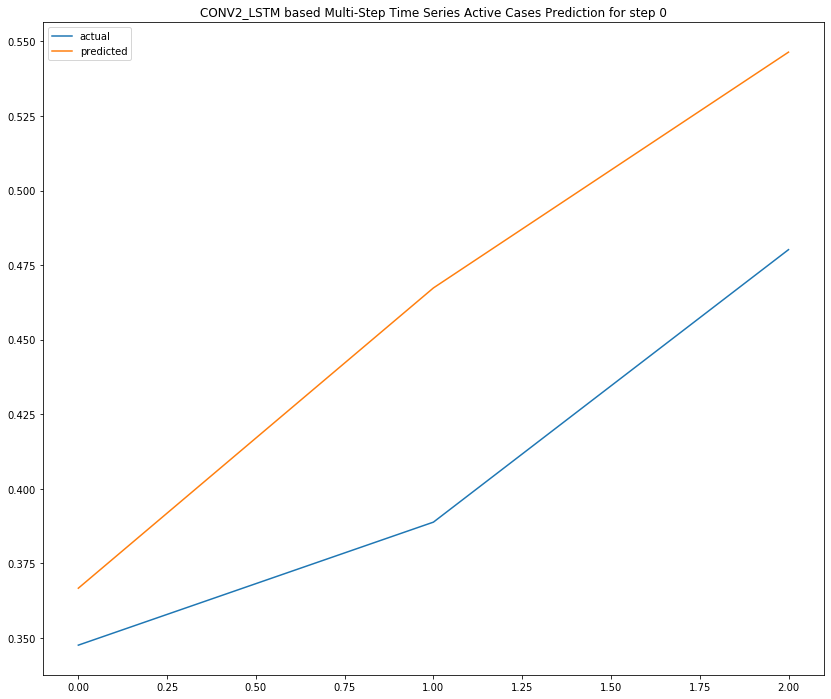

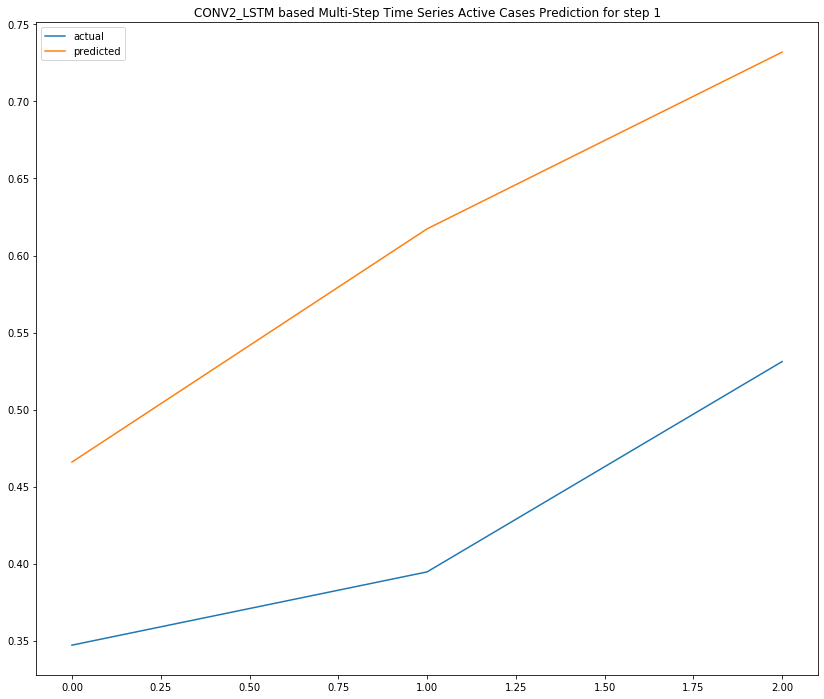

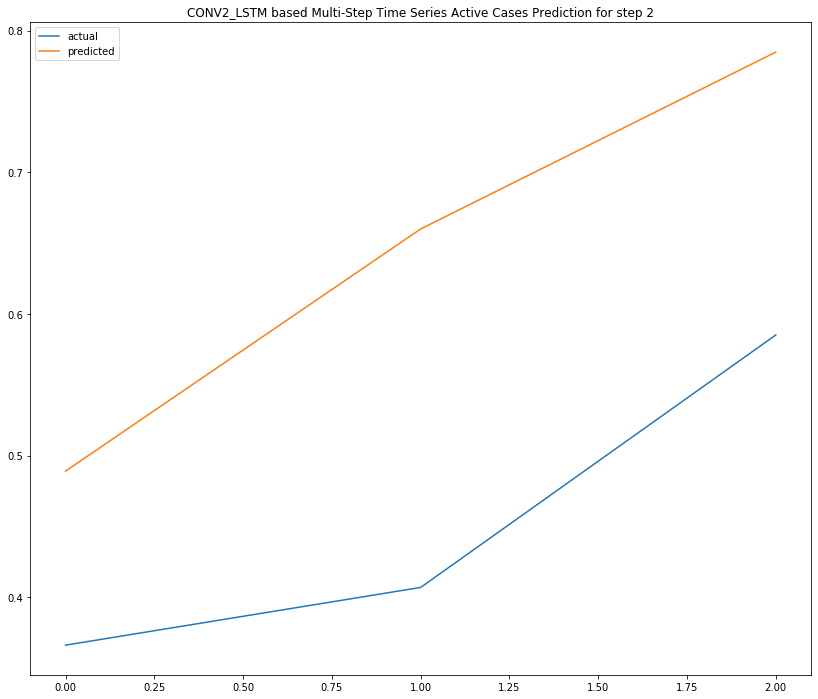

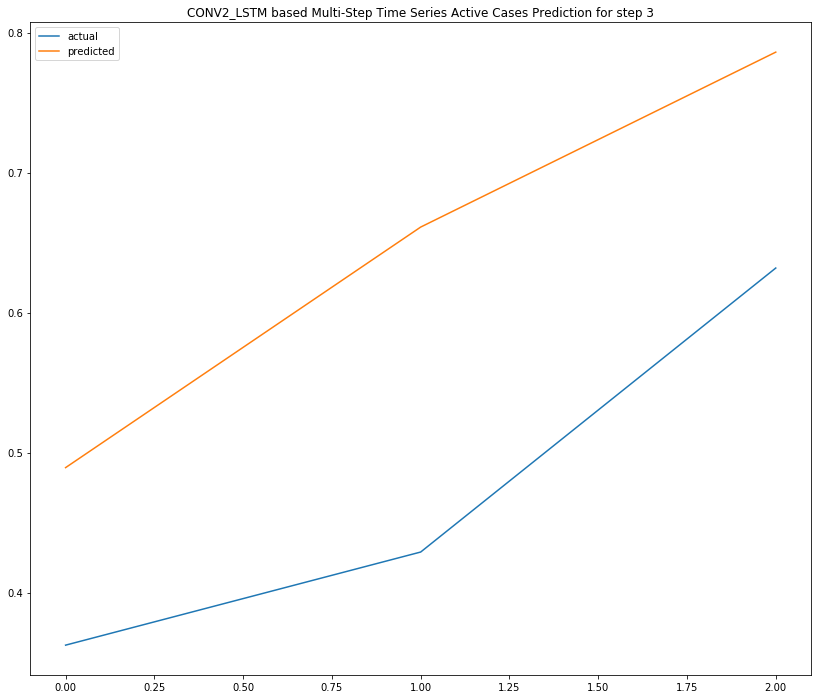

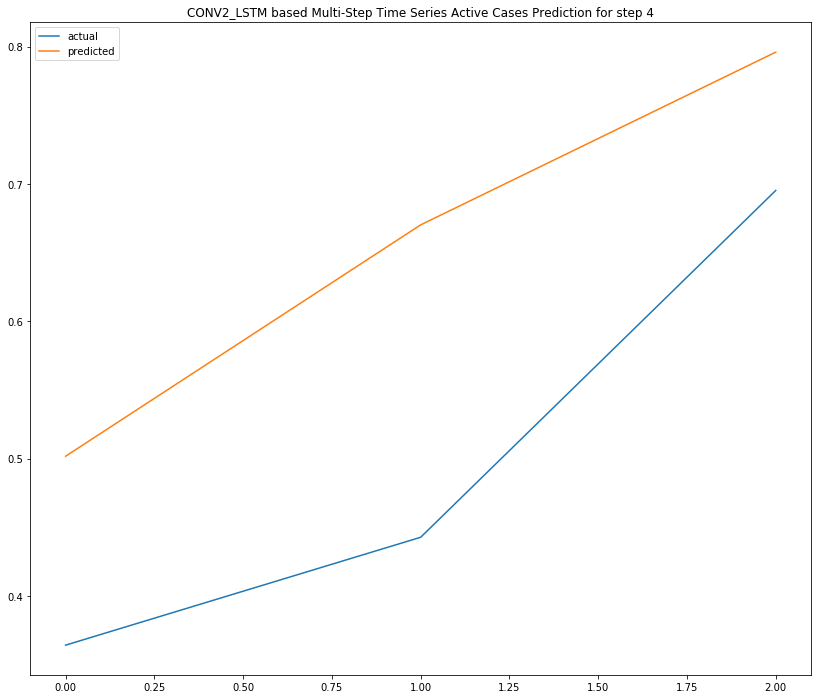

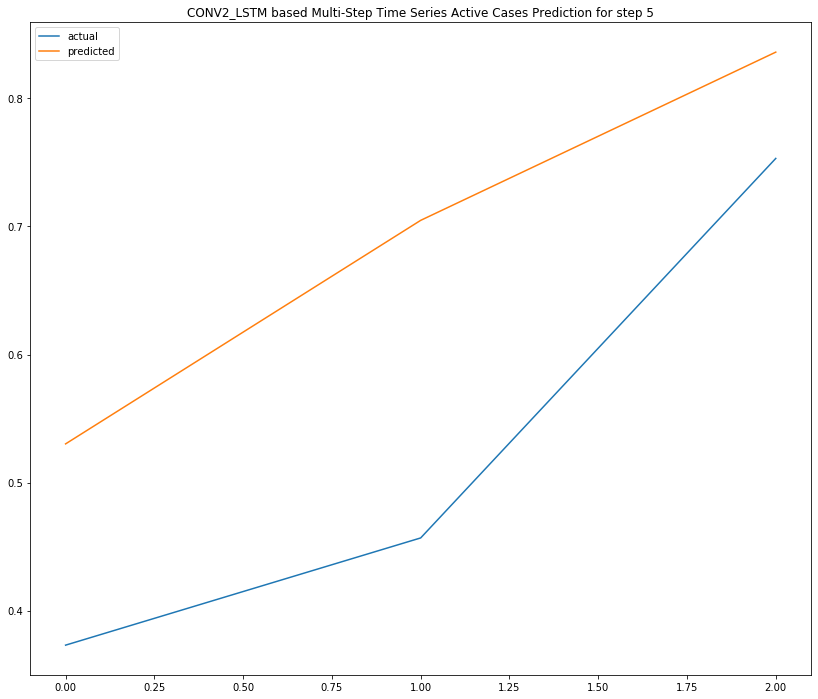

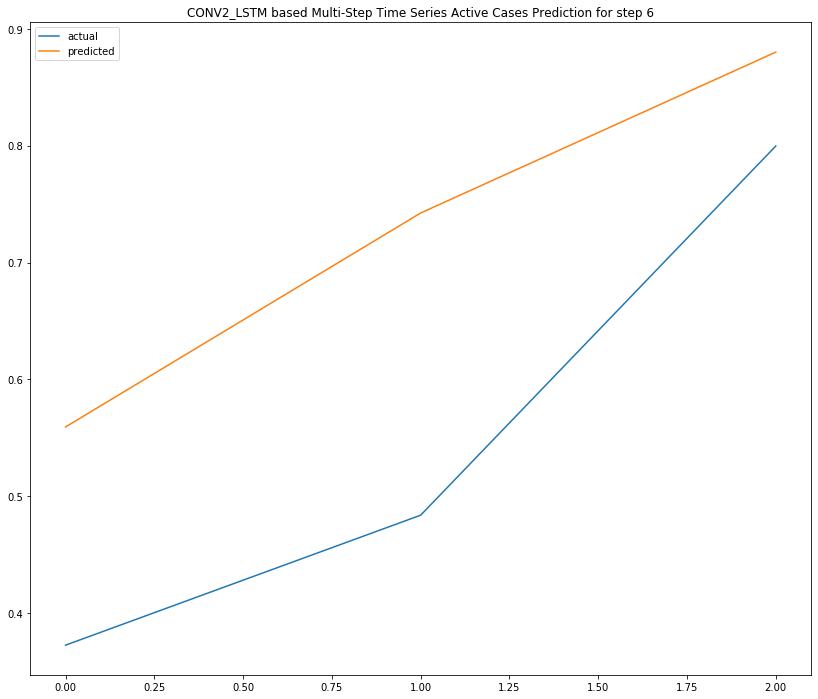

CONV2_LSTM: [0.170] 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2


In [90]:
# train CONV LSTM2D model
def build_model_cnn_lstm_2d(train, n_steps, n_length, n_input):
    
    # prepare data
    train_x, train_y = to_supervised_2cnn_lstm(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 750, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


# convert history into inputs and outputs
def to_supervised_2cnn_lstm(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
                      
# make a forecast
def forecast_2cnn_lstm(model, history, n_steps, n_length, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [samples, time steps, rows, cols, channels]
	input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model_2cnn_lstm(train, test, n_steps, n_length, n_input):
	# fit model
	model = build_model_cnn_lstm_2d(train, n_steps, n_length, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast_2cnn_lstm(model, history, n_steps, n_length, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, test[:, :, 0], predictions


df_state_all = pd.read_csv('all_states/all.csv')
df_state_all = df_state_all.drop(columns=['Latitude', 'Longitude', 'index'])
stateName = unique_states[8]


dataset = df_state_all[df_state_all['Name of State / UT'] == unique_states[8]]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-25') & (dataset['Date'] <= '2020-06-06')]

print(np.shape(dataset))
daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]
print(dateStart)
print(dateEnd)


dataset = dataset.drop(columns=['Unnamed: 0', 'Date', 'source1', 'state', 'Name of State / UT', 'tagpeopleinquarantine', 'tagtotaltested'])

print(np.shape(dataset))
n = np.shape(dataset)[0]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# split into train and test
train, test = split_dataset(scaled_dataset)

# define the number of subsequences and the length of subsequences
n_steps, n_length = 2, 7
# define the total days to use as input
n_input = n_length * n_steps
score, scores, actual, predicted = evaluate_model_2cnn_lstm(train, test, n_steps, n_length, n_input)
# summarize scores
summarize_scores(ModelType, score, scores)

2020-05-13
21 (21, 23)
2020-06-03
(21,)
(21,)


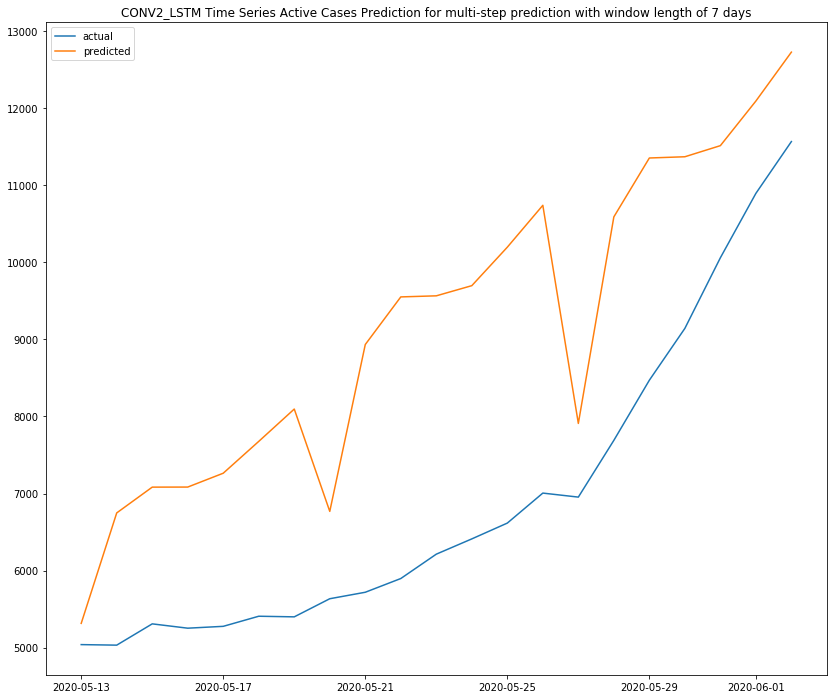

Test RMSE: 2459.311


In [91]:
test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
#print(np.shape(test))

actual = actual.reshape((actual.shape[0]*actual.shape[1], 1))
#print(np.shape(actual))

predicted = predicted.reshape((predicted.shape[0]*predicted.shape[1], 1))
#print(np.shape(predicted))


inv_pred = np.concatenate((predicted, test[:, 1:]), axis=1)
#print(np.shape(inv_pred))


inv_y = np.concatenate((actual, test[:, 1:]), axis=1)
#print(np.shape(inv_y))


inv_pred = scaler.inverse_transform(inv_pred)
#print(np.shape(inv_pred))
inv_pred = inv_pred[:, 0]

inv_y = scaler.inverse_transform(inv_y)
#print(np.shape(inv_y))
inv_y = inv_y[:, 0]



#For plotting
ind_dend=np.shape(test)[0]
ind_dstart =  np.shape(train)[0] *np.shape(train)[1]
dateStart = daterange[ind_dstart]
print(dateStart)
print(ind_dend,np.shape(test))
dateEnd = daterange[ind_dstart+ind_dend]
print(dateEnd)

pred_index= pd.date_range(start=dateStart, periods=ind_dend, freq='D')
print(np.shape(inv_y))
print(np.shape(inv_pred))

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_pred, pred_index)


plt.figure(figsize=(14, 12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title(ModelType +  ' Time Series Active Cases Prediction for multi-step prediction with window length of 7 days')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)

# Multi-Variate Multi-Step Conv2D + LSTM based Prediction for State Delhi

(73, 30)
2020-03-25
2020-06-05
(73, 23)
(73, 23)
Split Factor no is 51
Initials Train-Test Split -- (49, 23) (21, 23)
Final Train-Test Split -- (7, 7, 23) (3, 7, 23)
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_15 (ConvLSTM2D) (None, 1, 5, 64)          67072     
_________________________________________________________________
flatten_17 (Flatten)         (None, 320)               0         
_________________________________________________________________
repeat_vector_37 (RepeatVect (None, 7, 320)            0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 7, 200)            416800    
_________________________________________________________________
time_distributed_74 (TimeDis (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_75

W0823 15:37:10.974138 4595058112 def_function.py:120] 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x15c5040d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Data shape is forecast_2cnn_lstm (8, 7, 23) 7
Data and inp forecast_2cnn_lstm (56, 23) (7, 23)
Data shape is forecast_2cnn_lstm (9, 7, 23) 7
Data and inp forecast_2cnn_lstm (63, 23) (7, 23)
Actual Results (3, 7)
Predicted  Results (3, 7, 1)


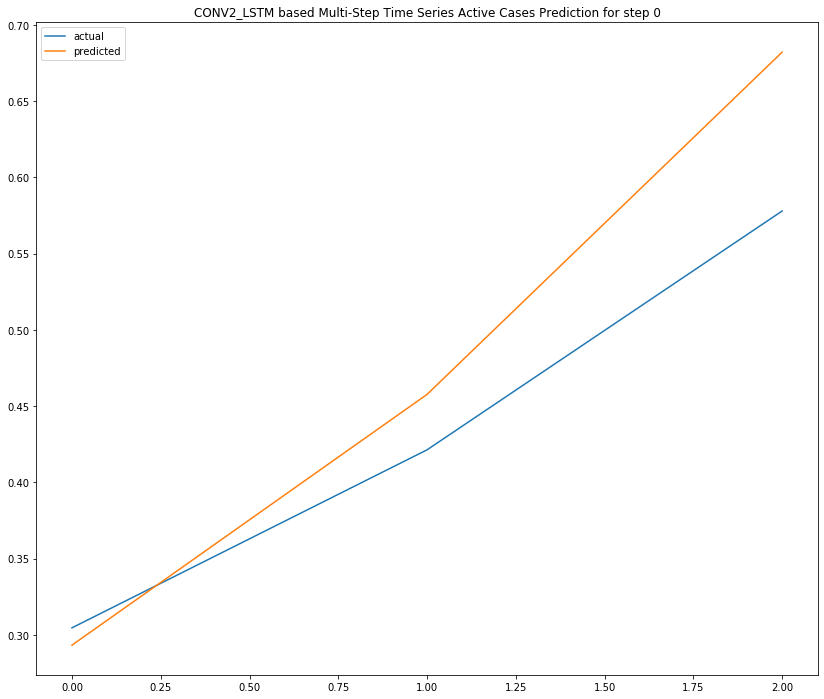

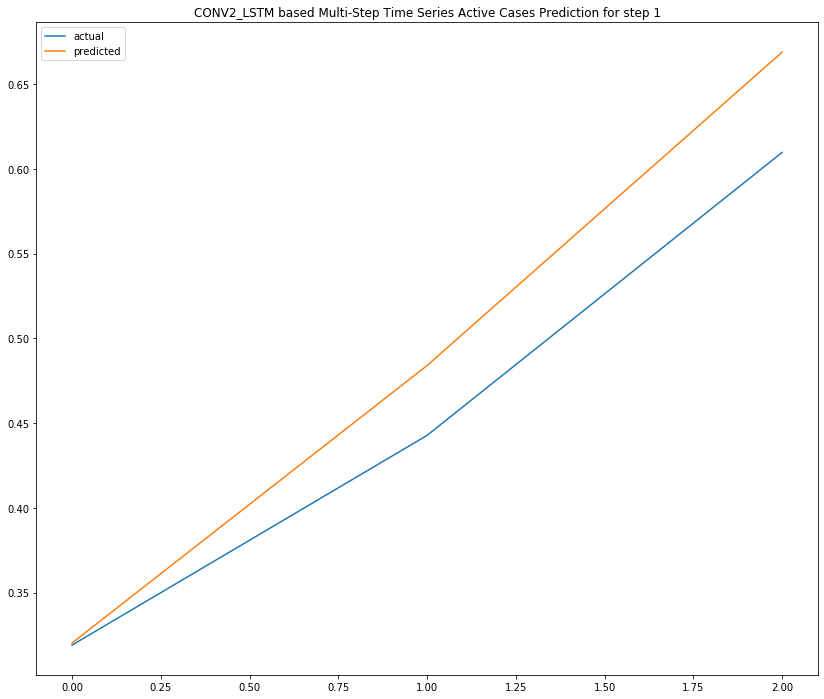

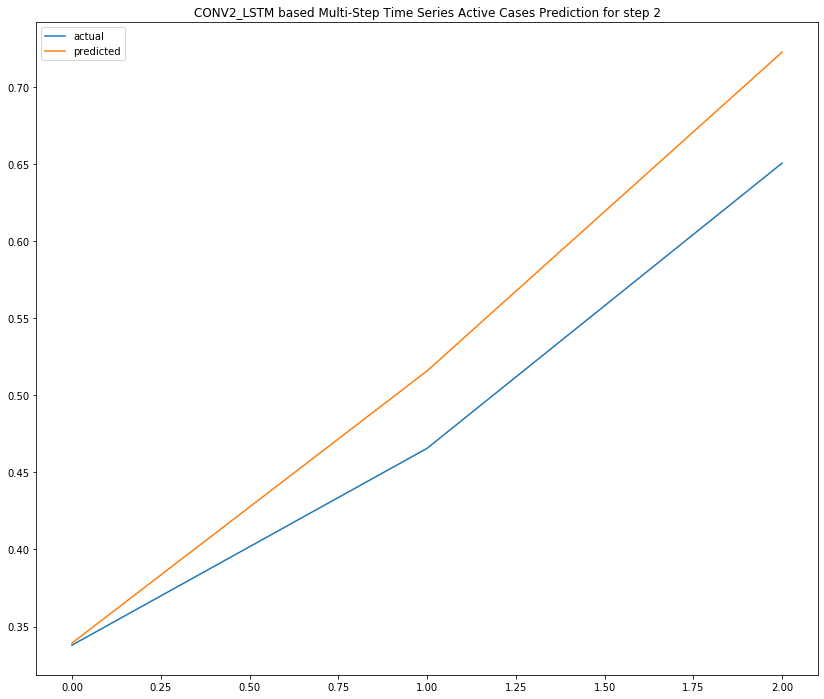

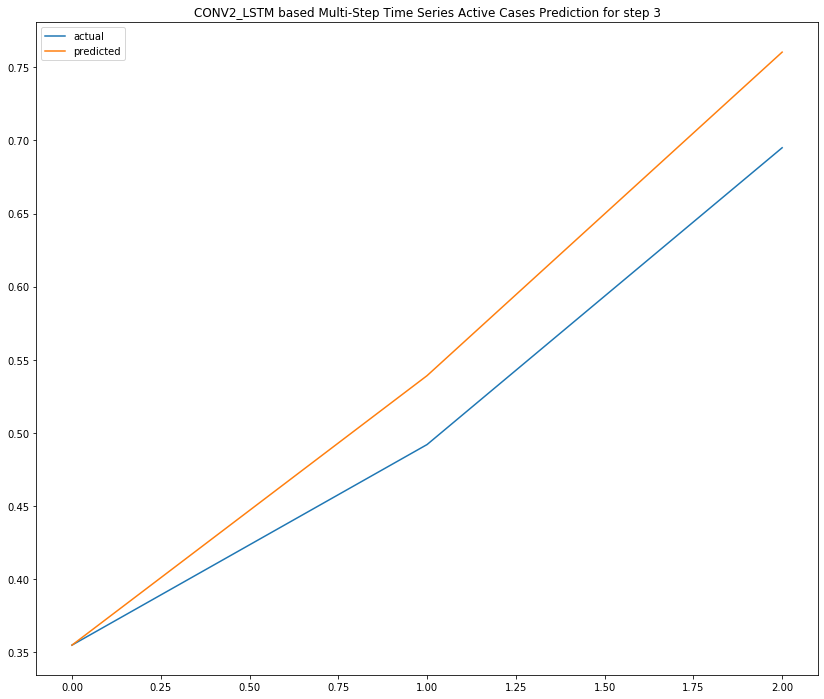

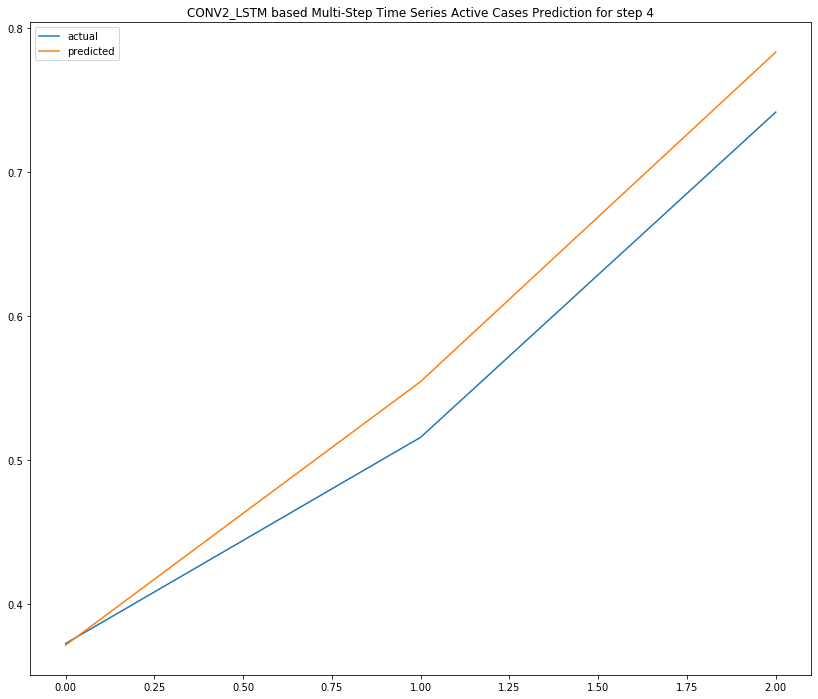

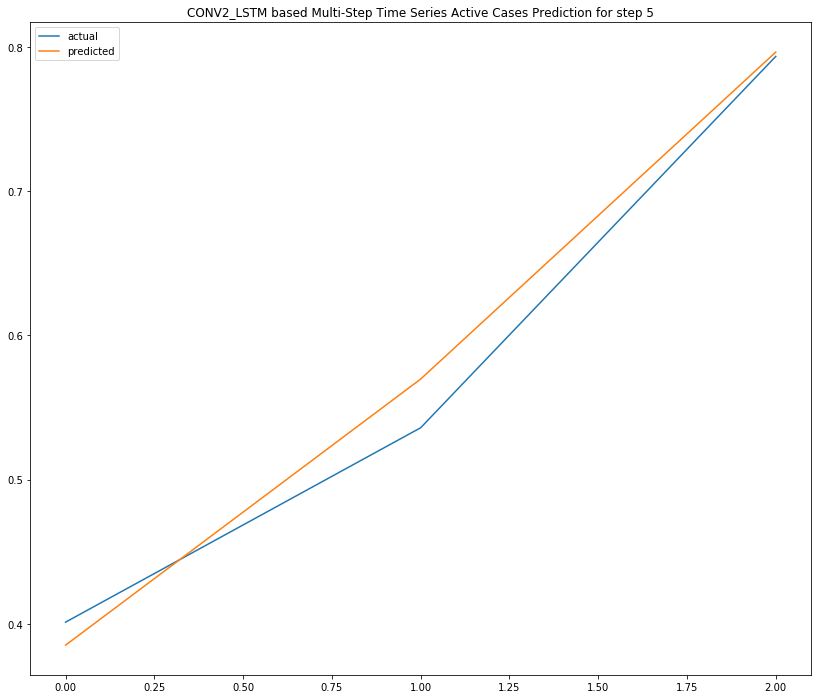

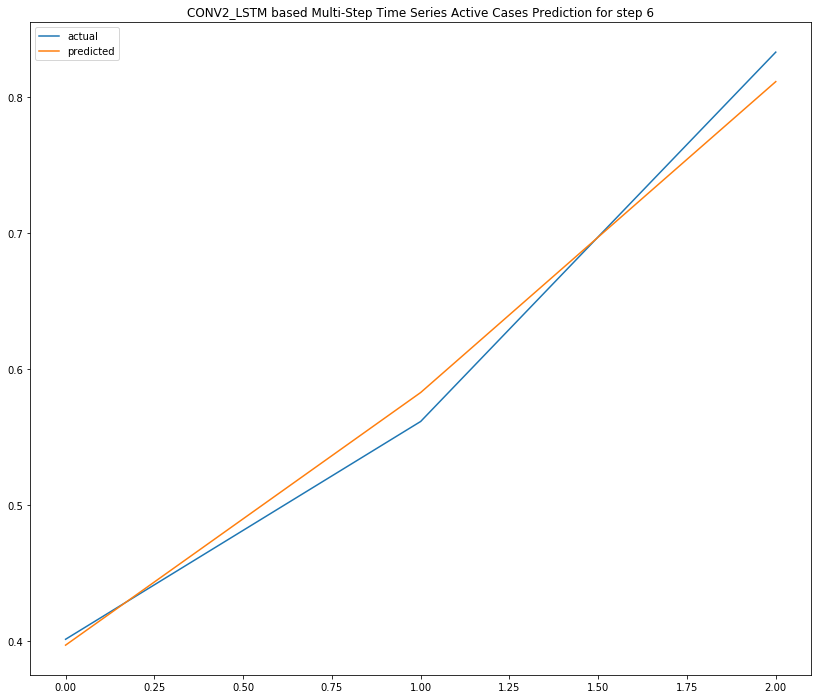

CONV2_LSTM: [0.042] 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0


In [244]:
# train CONV LSTM2D model
def build__multi_model_cnn_lstm_2d(train, n_steps, n_length, n_input):
    
    # prepare data
    train_x, train_y = to__multi_supervised_2cnn_lstm(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 750, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1]))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    print(model.summary())
    return model


# convert history into inputs and outputs
def to__multi_supervised_2cnn_lstm(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
    
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, :]
			x_input = x_input.reshape((len(x_input), x_input.shape[1]))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
                      
# make a forecast
def forecast__multi_2cnn_lstm(model, history, n_steps, n_length, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [samples, time steps, rows, cols, channels]
	input_x = input_x.reshape((1, n_steps, 1, n_length, data.shape[1]))  #train_x.shape[0], n_steps, 1, n_length, n_features
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_multi_model_2cnn_lstm(train, test, n_steps, n_length, n_input):
	# fit model
	model = build__multi_model_cnn_lstm_2d(train, n_steps, n_length, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast_2cnn_lstm(model, history, n_steps, n_length, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, test[:, :, 0], predictions


df_state_all = pd.read_csv('all_states/all.csv')
df_state_all = df_state_all.drop(columns=['Latitude', 'Longitude', 'index'])
stateName = unique_states[8]


dataset = df_state_all[df_state_all['Name of State / UT'] == unique_states[8]]
dataset = dataset.sort_values(by='Date', ascending=True)
dataset = dataset[(dataset['Date'] >= '2020-03-25') & (dataset['Date'] <= '2020-06-06')]

print(np.shape(dataset))
daterange = dataset['Date'].values
no_Dates = len(daterange)

dateStart = daterange[0]
dateEnd = daterange[no_Dates - 1]
print(dateStart)
print(dateEnd)


dataset = dataset.drop(columns=['Unnamed: 0', 'Date', 'source1', 'state', 'Name of State / UT', 'tagpeopleinquarantine', 'tagtotaltested'])

print(np.shape(dataset))
n = np.shape(dataset)[0]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

# split into train and test
train, test = split_dataset(scaled_dataset)

# define the number of subsequences and the length of subsequences
n_steps, n_length = 1, 7
# define the total days to use as input
n_input = n_length * n_steps
score, scores, actual, predicted = evaluate_multi_model_2cnn_lstm(train, test, n_steps, n_length, n_input)
# summarize scores
summarize_scores(ModelType, score, scores)

2020-05-13
21 (21, 23)
2020-06-03
(21,)
(21,)


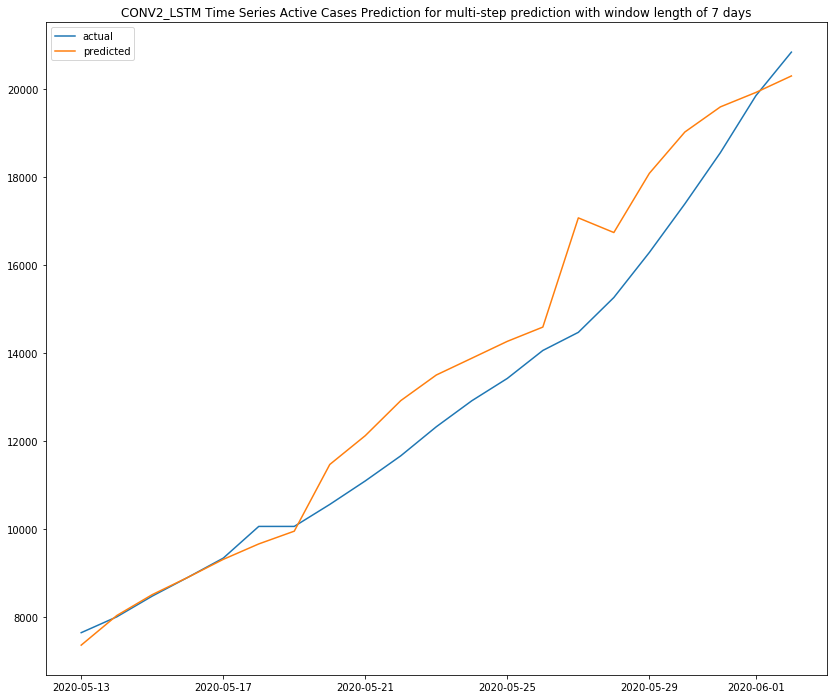

Test RMSE: 1052.235


In [245]:
test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
#print(np.shape(test))

actual = actual.reshape((actual.shape[0]*actual.shape[1], 1))
#print(np.shape(actual))

predicted = predicted.reshape((predicted.shape[0]*predicted.shape[1], 1))
#print(np.shape(predicted))


inv_pred = np.concatenate((predicted, test[:, 1:]), axis=1)
#print(np.shape(inv_pred))


inv_y = np.concatenate((actual, test[:, 1:]), axis=1)
#print(np.shape(inv_y))


inv_pred = scaler.inverse_transform(inv_pred)
#print(np.shape(inv_pred))
inv_pred = inv_pred[:, 0]

inv_y = scaler.inverse_transform(inv_y)
#print(np.shape(inv_y))
inv_y = inv_y[:, 0]



#For plotting
ind_dend=np.shape(test)[0]
ind_dstart =  np.shape(train)[0] *np.shape(train)[1]
dateStart = daterange[ind_dstart]
print(dateStart)
print(ind_dend,np.shape(test))
dateEnd = daterange[ind_dstart+ind_dend]
print(dateEnd)

pred_index= pd.date_range(start=dateStart, periods=ind_dend, freq='D')
print(np.shape(inv_y))
print(np.shape(inv_pred))

inv_y_actual =  pd.Series(inv_y, pred_index)
inv_y_predicted =  pd.Series(inv_pred, pred_index)


plt.figure(figsize=(14, 12))
plt.plot(inv_y_actual, label='actual')
plt.plot(inv_y_predicted, label='predicted')
plt.title(ModelType +  ' Time Series Active Cases Prediction for multi-step prediction with window length of 7 days')
plt.legend()
plt.show()

rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)